In [79]:

import pandas as pd
from pandas_profiling import ProfileReport as PR
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import style
import seaborn as sns
import plotly.graph_objects as go
import gc
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix,confusion_matrix, classification_report, accuracy_score

from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve
from sklearn import metrics, tree

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.tree import DecisionTreeClassifier 
from sklearn.impute import KNNImputer

import joblib

from imblearn.over_sampling import SMOTENC

from catboost import CatBoostClassifier, Pool

import shap

import warnings
warnings.filterwarnings("ignore")

style.use("fivethirtyeight")

# Import Dataset

In [3]:
df=pd.read_csv('/kaggle/input/hepatitis-c-dataset/HepatitisCdata.csv')

In [4]:
df.head()


Unnamed: 0       Category  Age Sex   ALB   ALP   ALT   AST   BIL    CHE  \
0           1  0=Blood Donor   32   m  38.5  52.5   7.7  22.1   7.5   6.93   
1           2  0=Blood Donor   32   m  38.5  70.3  18.0  24.7   3.9  11.17   
2           3  0=Blood Donor   32   m  46.9  74.7  36.2  52.6   6.1   8.84   
3           4  0=Blood Donor   32   m  43.2  52.0  30.6  22.6  18.9   7.33   
4           5  0=Blood Donor   32   m  39.2  74.1  32.6  24.8   9.6   9.15   

   CHOL   CREA   GGT  PROT  
0  3.23  106.0  12.1  69.0  
1  4.80   74.0  15.6  76.5  
2  5.20   86.0  33.2  79.3  
3  4.74   80.0  33.8  75.7  
4  4.32   76.0  29.9  68.7

# Data Handling

**Checking missing values**

In [5]:
df.isnull().sum()


Unnamed: 0     0
Category       0
Age            0
Sex            0
ALB            1
ALP           18
ALT            1
AST            0
BIL            0
CHE            0
CHOL          10
CREA           0
GGT            0
PROT           1
dtype: int64

ada beberapa kolom dengan missing value yaitu ALB,ALP,ALT,CHOL, dan PROT. Selanjutnya, missing value ini akan diperbaiki dengan diisi rata-rata dari data masing-masing kolom

In [6]:
df['ALB'].fillna(df['ALB'].mean(), inplace=True)
df['ALP'].fillna(df['ALP'].mean(), inplace=True)
df['CHOL'].fillna(df['CHOL'].mean(), inplace=True)
df['PROT'].fillna(df['PROT'].mean(), inplace=True)
df['ALT'].fillna(df['ALT'].mean(), inplace=True)

df.isnull().sum()


Unnamed: 0    0
Category      0
Age           0
Sex           0
ALB           0
ALP           0
ALT           0
AST           0
BIL           0
CHE           0
CHOL          0
CREA          0
GGT           0
PROT          0
dtype: int64

Sudah tidak terdapat missing values

**Checking duplicat values**

In [7]:
df.duplicated().sum()

0

tidak ada data duplikat. Data aman untuk proses handling selanjutnya

**Remove unecessary features**

In [8]:
df = df.drop('Unnamed: 0', axis=1)


**Grouping category class**

Melakukan grouping pada kolom Category dengan ketentuan 0=Blood Donor dan 0s=Suspect Blood Door menjadi 'Blood Donor', kemudian untuk 1=Hepatitis, 2=Fibrosis, 3=Cirrhosis menjadi 'Hepatitis C'. Selain itu untuk Sex, m diubah menjadi Male, dan f diubah menjadi Female

In [9]:
df['Category'] = df['Category'].replace({'0=Blood Donor': 'Blood Donor', '0s=suspect Blood Donor': 'Blood Donor', '1=Hepatitis': 'Hepatitis C', '2=Fibrosis': 'Hepatitis C', '3=Cirrhosis': 'Hepatitis C'})

df['Sex'] = df['Sex'].replace({'m': 'Male', 'f': 'Female'})


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Category  615 non-null    object 
 1   Age       615 non-null    int64  
 2   Sex       615 non-null    object 
 3   ALB       615 non-null    float64
 4   ALP       615 non-null    float64
 5   ALT       615 non-null    float64
 6   AST       615 non-null    float64
 7   BIL       615 non-null    float64
 8   CHE       615 non-null    float64
 9   CHOL      615 non-null    float64
 10  CREA      615 non-null    float64
 11  GGT       615 non-null    float64
 12  PROT      615 non-null    float64
dtypes: float64(10), int64(1), object(2)
memory usage: 62.6+ KB


In [11]:
# Value counts of categorical variables
print(df['Category'].value_counts())
print(df['Sex'].value_counts())

Blood Donor    540
Hepatitis C     75
Name: Category, dtype: int64
Male      377
Female    238
Name: Sex, dtype: int64


**Groping features category**

In [73]:
cats =['Category','Sex']
num = ['Age','ALB','ALP','ALT','AST','BIL','CHE','CHOL','CREA','GGT','PROT']
col=['Category', 'Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE',
       'CHOL', 'CREA', 'GGT', 'PROT']
feat=[ 'Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE',
       'CHOL', 'CREA', 'GGT', 'PROT']

# Exploratory Data Analysis

**Summary of Data**

In [13]:
def summary_tab(df):
  summary = pd.DataFrame({
      'Kolom': df.columns,
      'dataType': df.dtypes,
      'jumlah_baris': len(df),
      'null' : df.isna().sum(),
      'null_percentage' : round(df.isna().sum()/len(df)*100,2),
      'unique' : df.nunique(),
      'unique_sample' : [list(df[i].drop_duplicates().sample(2)) for i in df.columns]
  })
  summary['unique_%'] = round(summary['unique'] / len(df) * 100,2)
  return summary.reset_index(drop=True)

In [14]:
summary_tab(df)

Kolom dataType  jumlah_baris  null  null_percentage  unique  \
0   Category   object           615     0              0.0       2   
1        Age    int64           615     0              0.0      49   
2        Sex   object           615     0              0.0       2   
3        ALB  float64           615     0              0.0     190   
4        ALP  float64           615     0              0.0     415   
5        ALT  float64           615     0              0.0     342   
6        AST  float64           615     0              0.0     297   
7        BIL  float64           615     0              0.0     188   
8        CHE  float64           615     0              0.0     407   
9       CHOL  float64           615     0              0.0     314   
10      CREA  float64           615     0              0.0     117   
11       GGT  float64           615     0              0.0     358   
12      PROT  float64           615     0              0.0     199   

                 unique_sample  unique_%  
0   [Hepatitis C, Blood Donor]      0.33  
1                     [70, 67]      7.97  
2               [Male, Female]      0.33  
3                 [62.9, 46.4]     30.89  
4                 [84.7, 82.7]     67.48  
5                 [23.7, 18.5]     55.61  
6                 [15.7, 20.0]     48.29  
7                  [7.7, 18.0]     30.57  
8               [10.08, 10.92]     66.18  
9                 [5.75, 5.04]     51.06  
10                [74.0, 73.0]     19.02  
11                [30.3, 36.2]     58.21  
12                [68.2, 68.7]     32.36

**Dimension of data**

In [15]:
df.shape

(615, 13)

**Top 5 of data**

In [16]:
df.head(5)

Category  Age   Sex   ALB   ALP   ALT   AST   BIL    CHE  CHOL   CREA  \
0  Blood Donor   32  Male  38.5  52.5   7.7  22.1   7.5   6.93  3.23  106.0   
1  Blood Donor   32  Male  38.5  70.3  18.0  24.7   3.9  11.17  4.80   74.0   
2  Blood Donor   32  Male  46.9  74.7  36.2  52.6   6.1   8.84  5.20   86.0   
3  Blood Donor   32  Male  43.2  52.0  30.6  22.6  18.9   7.33  4.74   80.0   
4  Blood Donor   32  Male  39.2  74.1  32.6  24.8   9.6   9.15  4.32   76.0   

    GGT  PROT  
0  12.1  69.0  
1  15.6  76.5  
2  33.2  79.3  
3  33.8  75.7  
4  29.9  68.7

**Descriptive Statistics**

statitik untuk kolom dengan type numerik

In [17]:
df.describe()

Age         ALB         ALP         ALT         AST         BIL  \
count  615.000000  615.000000  615.000000  615.000000  615.000000  615.000000   
mean    47.408130   41.620195   68.283920   28.450814   34.786341   11.396748   
std     10.055105    5.775920   25.643955   25.448940   33.090690   19.673150   
min     19.000000   14.900000   11.300000    0.900000   10.600000    0.800000   
25%     39.000000   38.800000   52.950000   16.400000   21.600000    5.300000   
50%     47.000000   41.900000   66.700000   23.000000   25.900000    7.300000   
75%     54.000000   45.200000   79.300000   33.050000   32.900000   11.200000   
max     77.000000   82.200000  416.600000  325.300000  324.000000  254.000000   

              CHE        CHOL         CREA         GGT        PROT  
count  615.000000  615.000000   615.000000  615.000000  615.000000  
mean     8.196634    5.368099    81.287805   39.533171   72.044137  
std      2.205657    1.123466    49.756166   54.661071    5.398234  
min      1.420000    1.430000     8.000000    4.500000   44.800000  
25%      6.935000    4.620000    67.000000   15.700000   69.300000  
50%      8.260000    5.310000    77.000000   23.300000   72.200000  
75%      9.590000    6.055000    88.000000   40.200000   75.400000  
max     16.410000    9.670000  1079.100000  650.900000   90.000000

statistik untuk kolom dengan type object

In [18]:
df.describe(include='object')

Category   Sex
count           615   615
unique            2     2
top     Blood Donor  Male
freq            540   377

**Univariate Analysis**

boxplot data

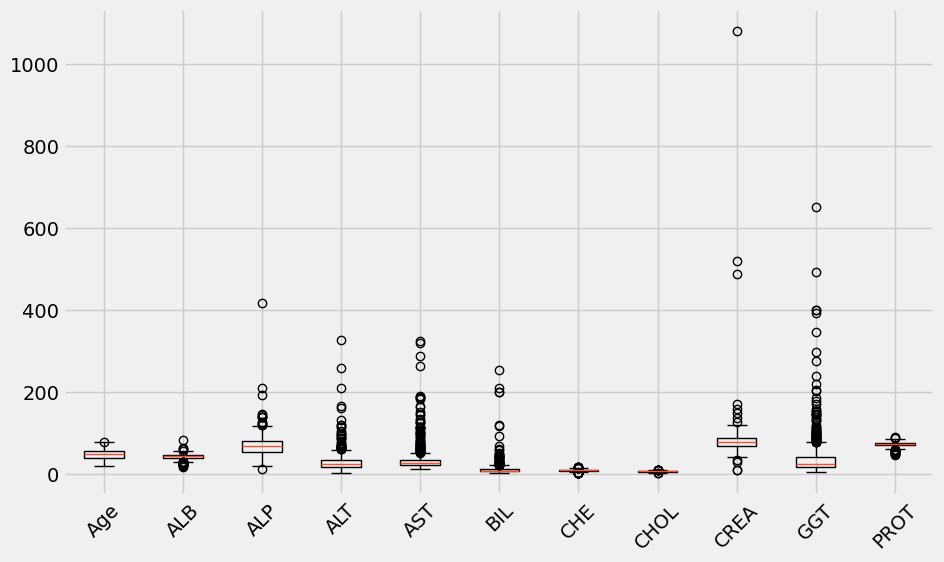

In [19]:
# create a box plot for each column
plt.figure(figsize=(10,6))
plt.boxplot(df[num].values, labels=num, showfliers=True)
plt.xticks(rotation=45)
plt.show()


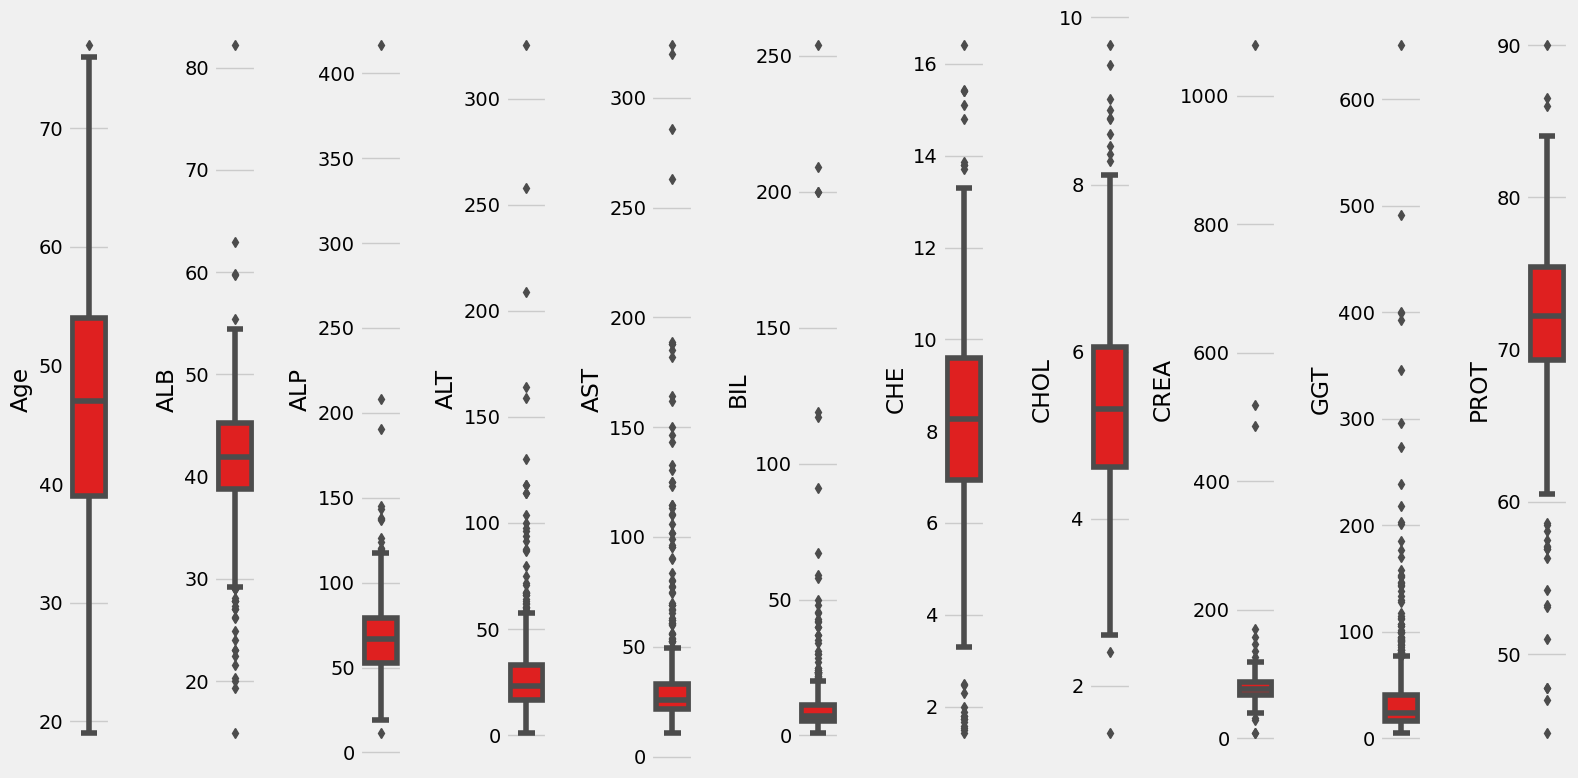

In [20]:
# adjust the figure size for better readability
plt.figure(figsize=(16,8))
# plotting
features = num
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=df[features[i]], color='red')
    plt.tight_layout()


plt.show()

**Checking Outlier**

In [21]:
df_num = df[num]
df_num.describe()

Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1
IQR
((df_num < (Q1 - 1.5 * IQR)) | (df_num > (Q3 + 1.5 * IQR))).any()

Age     True
ALB     True
ALP     True
ALT     True
AST     True
BIL     True
CHE     True
CHOL    True
CREA    True
GGT     True
PROT    True
dtype: bool

In [22]:

df_outliers = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q1 + 1.5 * IQR))]
outlier_percentage = (df_outliers.count() / len(df_outliers)) * 100
print(outlier_percentage)


Category     0.000000
Age          8.780488
Sex          0.000000
ALB         10.081301
ALP         10.081301
ALT         13.495935
AST         17.073171
BIL         15.772358
CHE         10.243902
CHOL        10.731707
CREA        11.056911
GGT         18.699187
PROT        12.032520
dtype: float64


Dapat dilihat bahwa nilai diata merupakan perentase dari outliers pada masing-maing kolom. Akan tetapi nilai outliers terebut tidak akan dihapus atau diubah, karenya disinyalir merupakan nilai hasil observasi pada sampel.

**Bivariate Analysis**

*Pair plot* digunakan untuk melihat sebaran data berdasarkan 2 variabel. Kali ini akan dilihat sebaran data Category terhadap variabel lainnya.

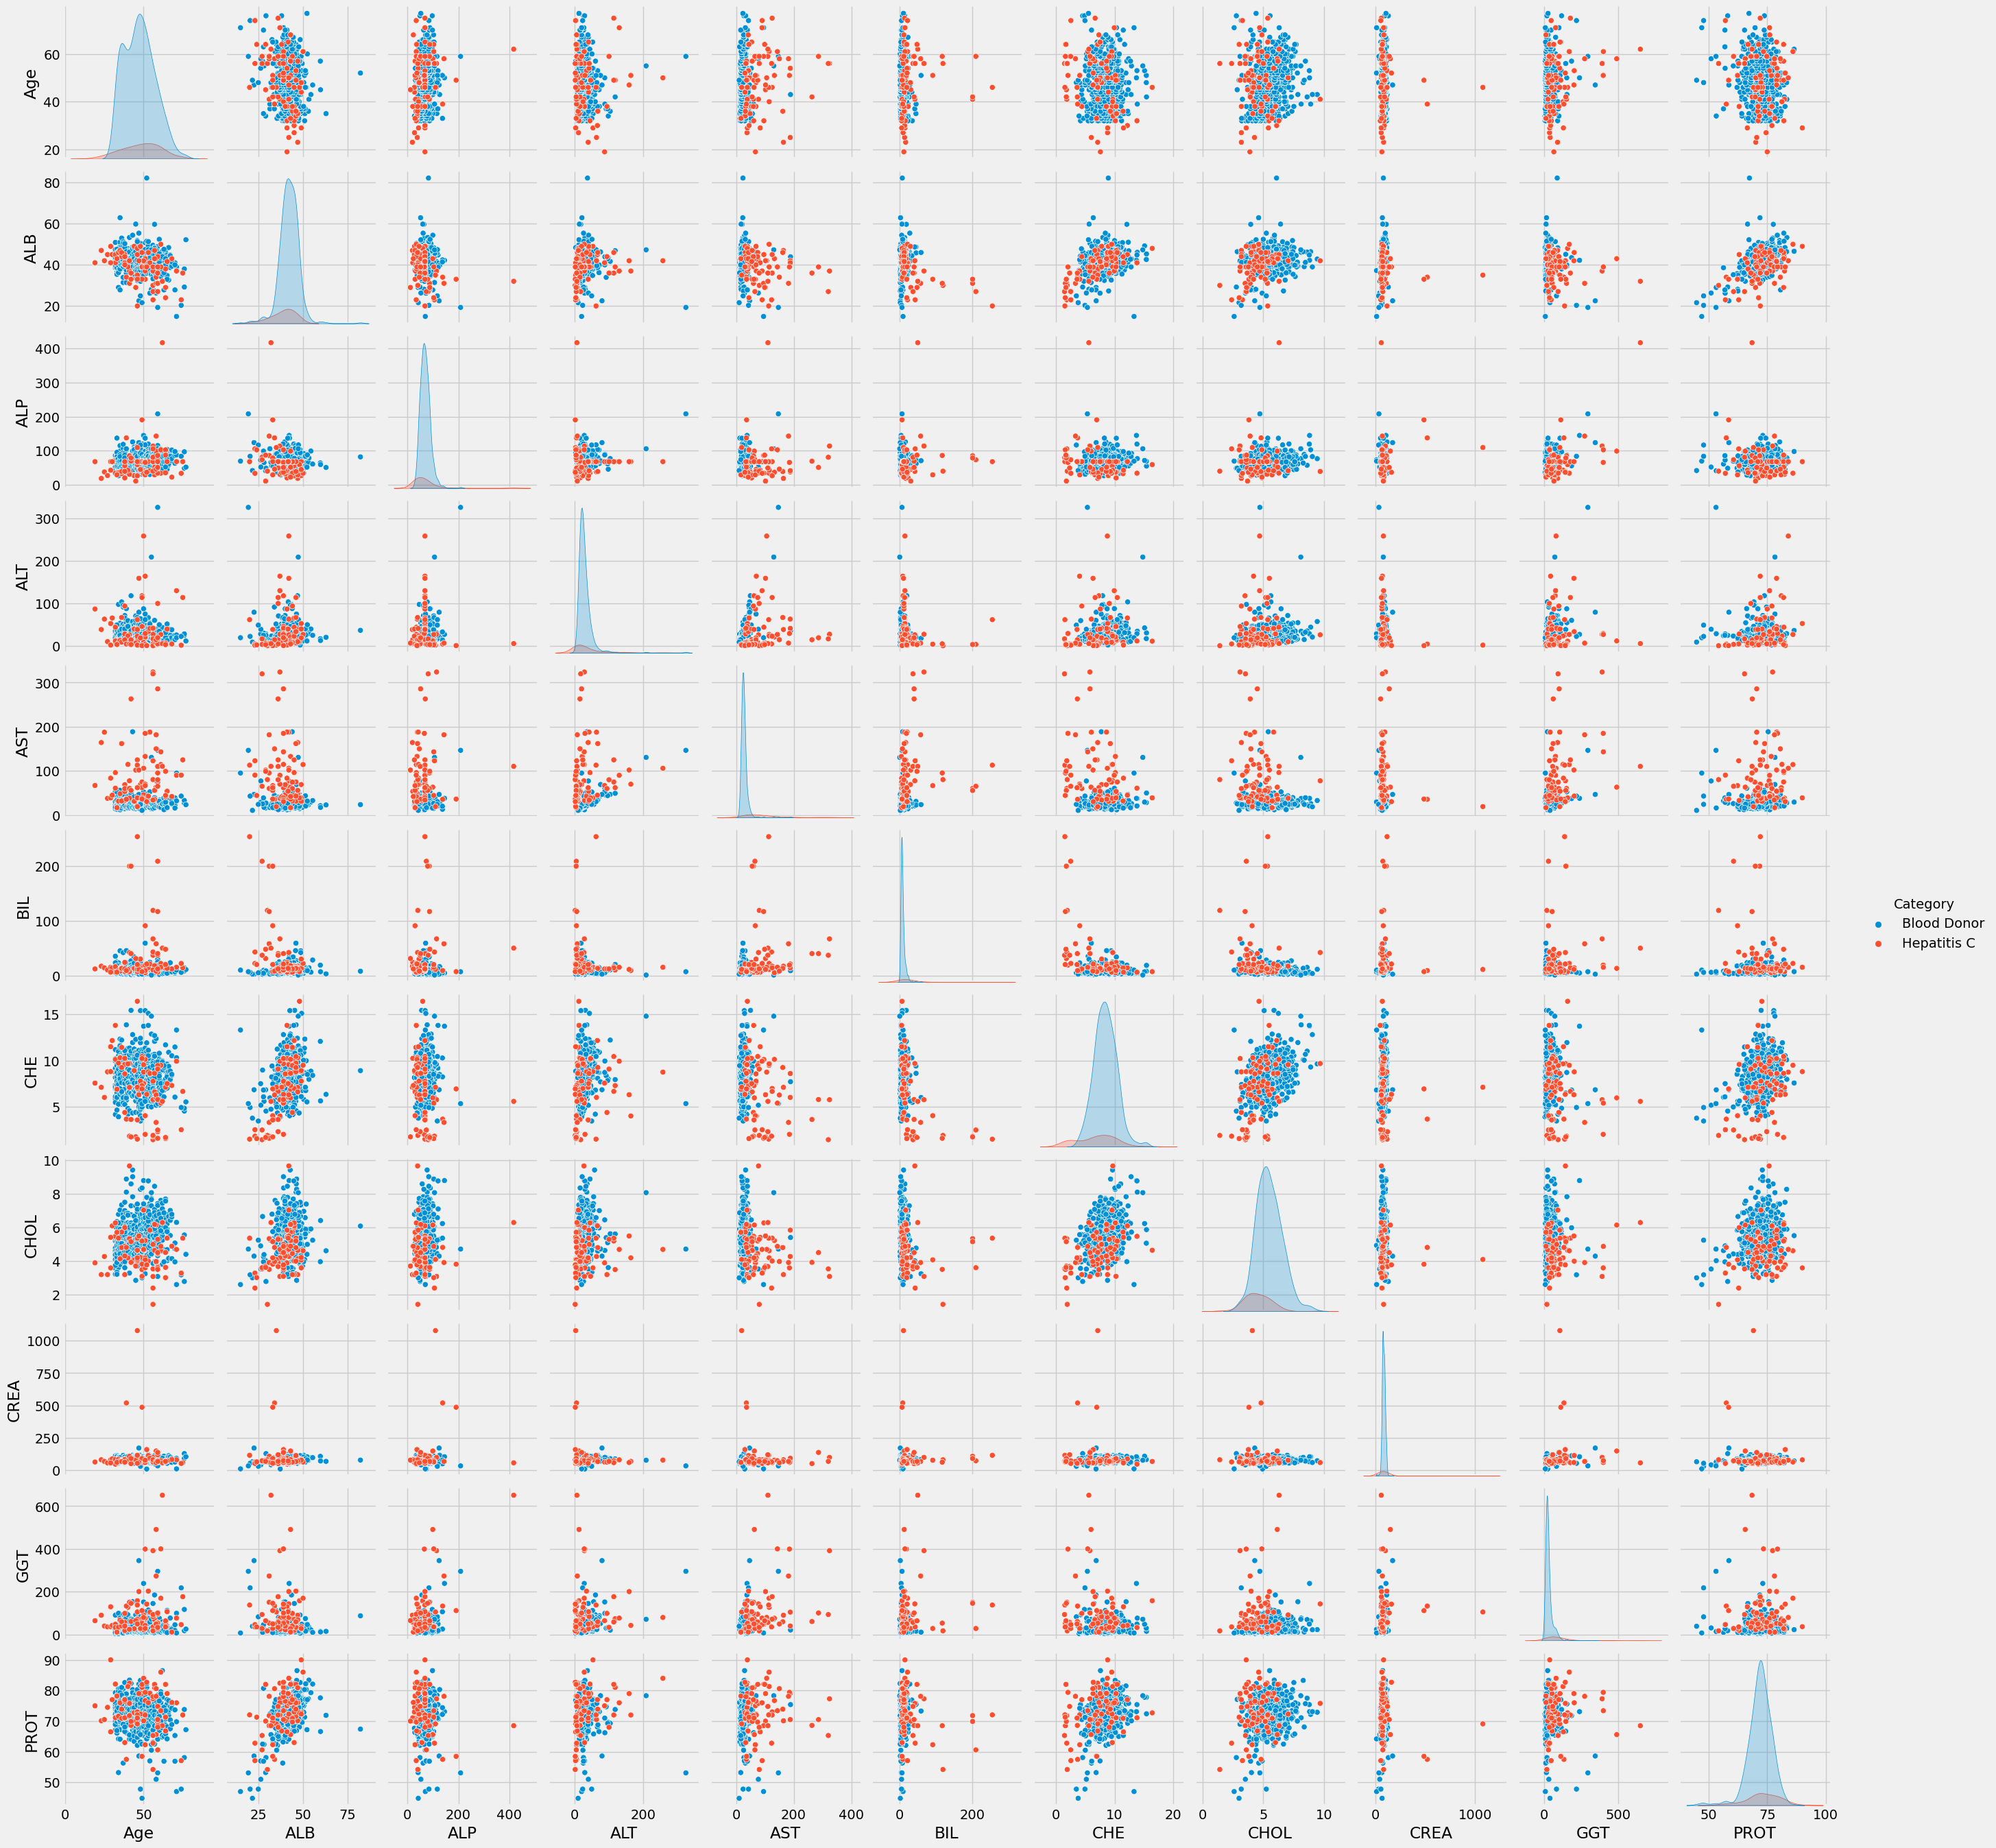

In [23]:
sns.pairplot(data=df,hue='Category')

**Perbandingan Pasien Hepatitis C dengan Donor Darah**

Text(0.5, 1.0, 'Jumlah Pasien Hepatitis C and Donor Darah')

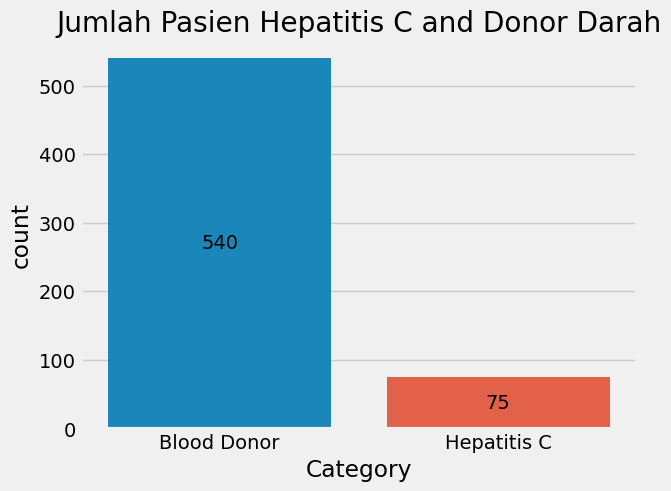

In [24]:
a= sns.countplot(data=df,x='Category')
a.bar_label(a.containers[0],label_type='center')
plt.title('Jumlah Pasien Hepatitis C and Donor Darah')

**Jumlah pasien berdasarkan jenis kelamin**

In [25]:
df.groupby(['Sex','Category'])['Category'].count()

Sex     Category   
Female  Blood Donor    216
        Hepatitis C     22
Male    Blood Donor    324
        Hepatitis C     53
Name: Category, dtype: int64

In [26]:
px.histogram(df,x='Sex',color='Category',template='plotly_dark',barmode='group', histfunc="count", nbins=10, text_auto=True,
             color_discrete_sequence=['#71AEC2 ','#D58989'],title='Distribution of sick and the healthy')


**Jumlah pasien berdasar rentang umur**

*Distribusi umur*

<AxesSubplot:xlabel='Age', ylabel='Density'>

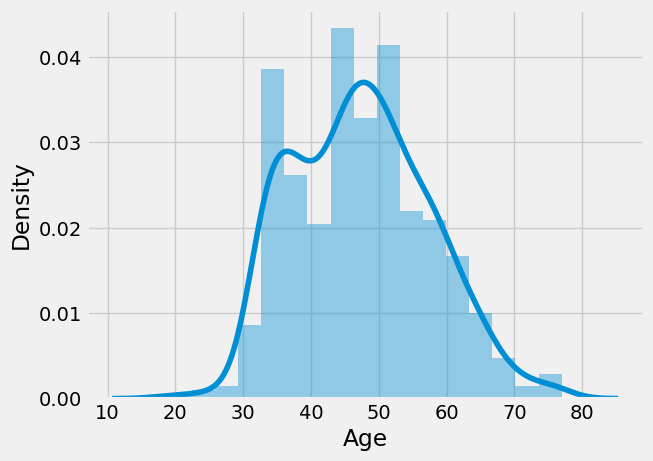

In [27]:
sns.distplot(df['Age'])

*membuat kolom rentang umur*

In [28]:
df["age_cat"]=pd.cut(df["Age"], [ 10, 20, 30, 40, 50,60,70,80])
df.head(2)

Category  Age   Sex   ALB   ALP   ALT   AST  BIL    CHE  CHOL   CREA  \
0  Blood Donor   32  Male  38.5  52.5   7.7  22.1  7.5   6.93  3.23  106.0   
1  Blood Donor   32  Male  38.5  70.3  18.0  24.7  3.9  11.17  4.80   74.0   

    GGT  PROT   age_cat  
0  12.1  69.0  (30, 40]  
1  15.6  76.5  (30, 40]

*Jumlah pasien berdasar rentan umur*

In [29]:
df[["age_cat","Category"]].groupby("age_cat",as_index=False).count().sort_values(by='Category',ascending=False).style.background_gradient(cmap='Reds')

*Menghitung jumlah pasien berdasar rentang umur dan kategori pasien*

In [30]:
df.groupby(['age_cat','Category'])['Category'].count()

age_cat   Category   
(10, 20]  Blood Donor      0
          Hepatitis C      1
(20, 30]  Blood Donor      0
          Hepatitis C      6
(30, 40]  Blood Donor    154
          Hepatitis C     13
(40, 50]  Blood Donor    189
          Hepatitis C     21
(50, 60]  Blood Donor    145
          Hepatitis C     23
(60, 70]  Blood Donor     46
          Hepatitis C      8
(70, 80]  Blood Donor      6
          Hepatitis C      3
Name: Category, dtype: int64

*Sebaran umur berdasar jenis kelamin*

In [31]:
fig = px.histogram(df, x="Age", color="Sex",histfunc="count", template='plotly_dark',nbins=10, text_auto=True)
fig.show()

*Menghitungg persentase jenis kelamin pasien pada masing-masing kategori umur*

In [32]:
df.pivot_table(index='Sex',columns='age_cat',values='Category',aggfunc='count')

age_cat  (10, 20]  (20, 30]  (30, 40]  (40, 50]  (50, 60]  (60, 70]  (70, 80]
Sex                                                                          
Female          0         0        57        86        76        18         1
Male            1         6       110       124        92        36         8

array([[<AxesSubplot:ylabel='(10, 20]'>, <AxesSubplot:ylabel='(20, 30]'>,
        <AxesSubplot:ylabel='(30, 40]'>, <AxesSubplot:ylabel='(40, 50]'>],
       [<AxesSubplot:ylabel='(50, 60]'>, <AxesSubplot:ylabel='(60, 70]'>,
        <AxesSubplot:ylabel='(70, 80]'>, <AxesSubplot:>]], dtype=object)

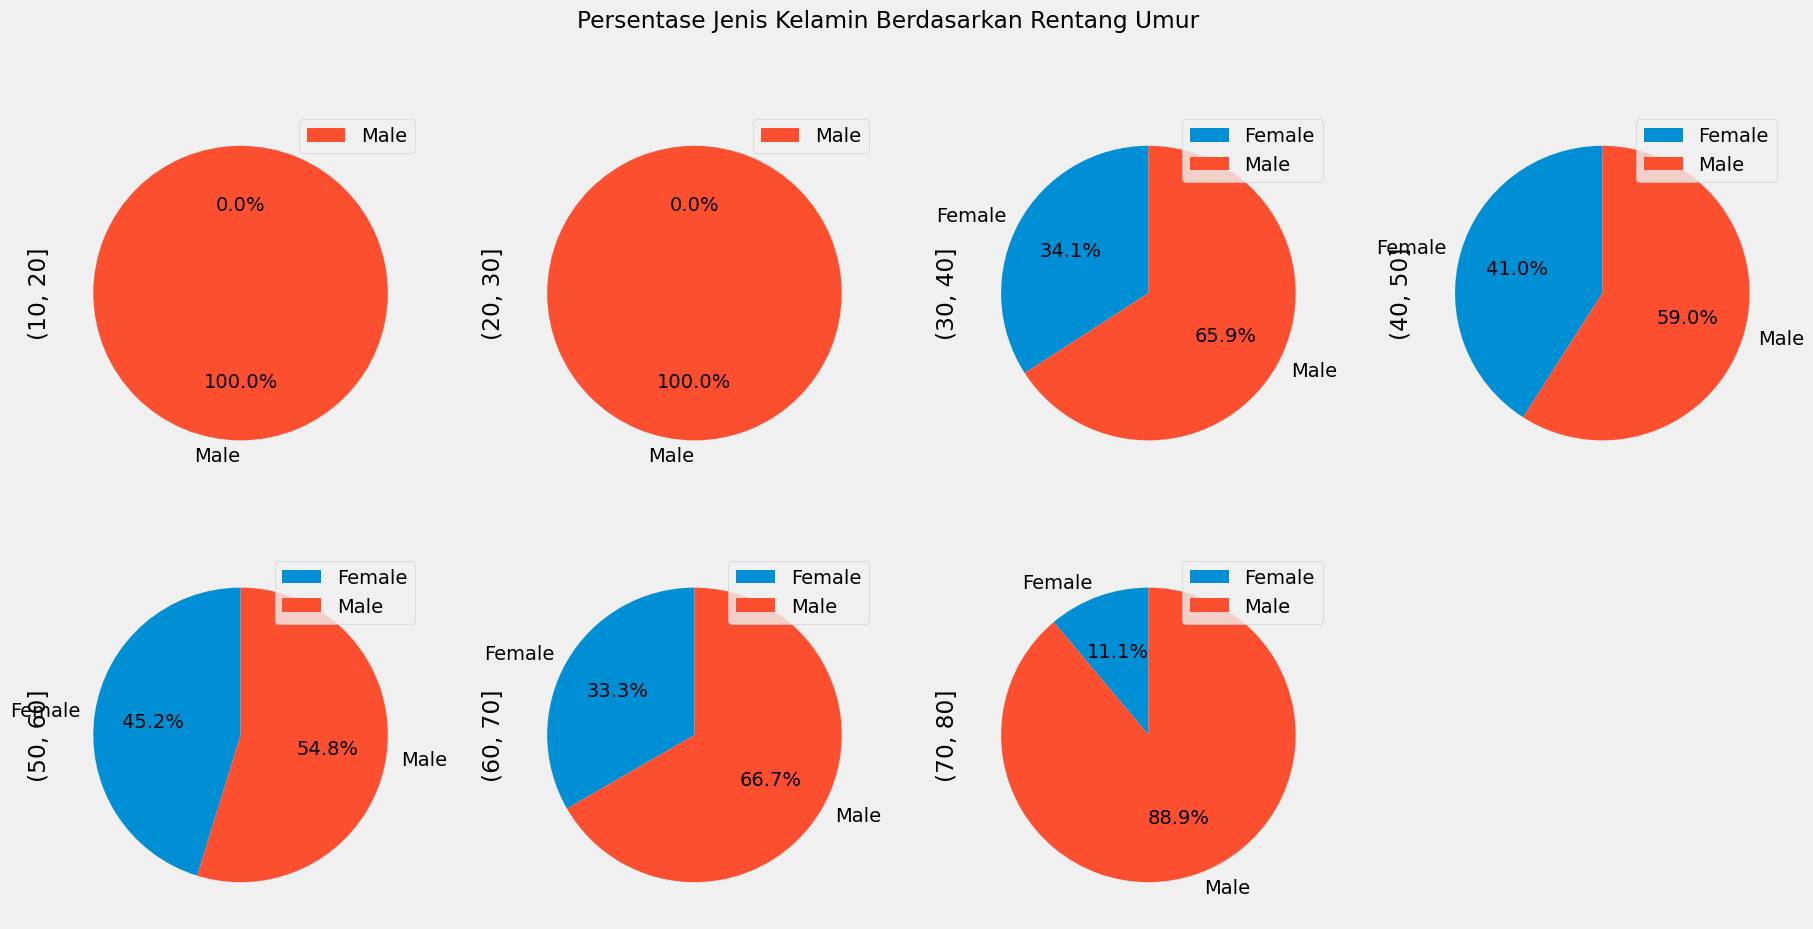

In [33]:
df.pivot_table(index='Sex',columns='age_cat',values='Category',aggfunc='count').plot.pie(subplots=True,grid=True,layout=(2,4), startangle=90,
            figsize=(20,10),title='Persentase Jenis Kelamin Berdasarkan Rentang Umur ',autopct ='%1.1f%%')

**Correlation matrix**

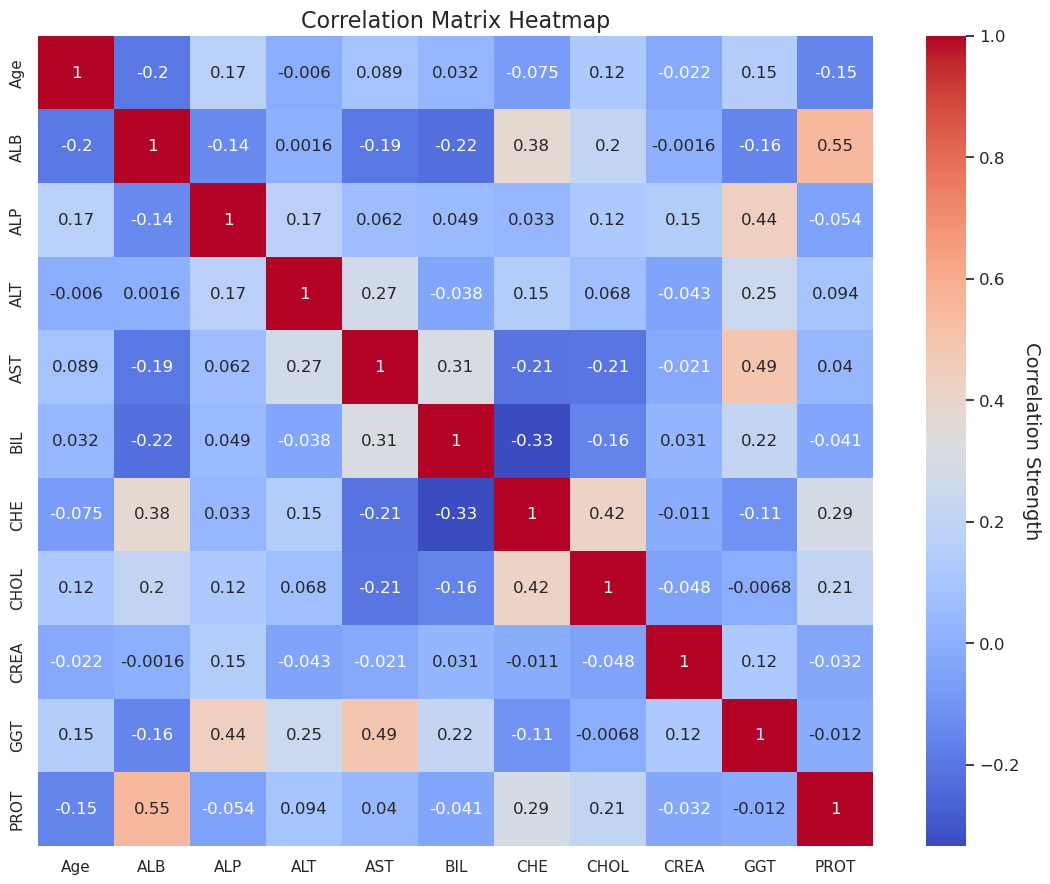

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
correlation_matrix = df.corr()
fig, ax = plt.subplots(figsize=(12, 10))
plt.title("Correlation Matrix Heatmap", fontsize=16)
sns.heatmap(correlation_matrix, annot=True, annot_kws={"size": 12}, cmap='coolwarm', ax=ax)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Correlation Strength', rotation=270, fontsize=14, labelpad=15)
plt.show()


In [35]:
fig = px.imshow(correlation_matrix, text_auto=True, aspect="auto",template='plotly_dark', title='Correlation Matrix of Numerical Features', labels=dict( color="Correlation Strength"))
fig.show()

# Data Preparation

In [36]:
dt1 = df.copy()
dt1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Category  615 non-null    object  
 1   Age       615 non-null    int64   
 2   Sex       615 non-null    object  
 3   ALB       615 non-null    float64 
 4   ALP       615 non-null    float64 
 5   ALT       615 non-null    float64 
 6   AST       615 non-null    float64 
 7   BIL       615 non-null    float64 
 8   CHE       615 non-null    float64 
 9   CHOL      615 non-null    float64 
 10  CREA      615 non-null    float64 
 11  GGT       615 non-null    float64 
 12  PROT      615 non-null    float64 
 13  age_cat   615 non-null    category
dtypes: category(1), float64(10), int64(1), object(2)
memory usage: 63.9+ KB


**Remove unecessary features**

In [37]:

dt1.drop(['age_cat'],axis=1,inplace=True)

**Feature Engineering**

In [38]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#object_col = [col for col in df.columns if df[col].dtypes == 'object']
#for col in object_col:
for col in [col for col in dt1.columns if dt1[col].dtypes == 'object']:
    dt1[col] = le.fit_transform(dt1[col].astype(str))
dt1.head()

Category  Age  Sex   ALB   ALP   ALT   AST   BIL    CHE  CHOL   CREA   GGT  \
0         0   32    1  38.5  52.5   7.7  22.1   7.5   6.93  3.23  106.0  12.1   
1         0   32    1  38.5  70.3  18.0  24.7   3.9  11.17  4.80   74.0  15.6   
2         0   32    1  46.9  74.7  36.2  52.6   6.1   8.84  5.20   86.0  33.2   
3         0   32    1  43.2  52.0  30.6  22.6  18.9   7.33  4.74   80.0  33.8   
4         0   32    1  39.2  74.1  32.6  24.8   9.6   9.15  4.32   76.0  29.9   

   PROT  
0  69.0  
1  76.5  
2  79.3  
3  75.7  
4  68.7

**Features Scaling**

In [39]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()

dt1['Age'] = scaler.fit_transform(dt1['Age'].values.reshape(len(dt1),1))
dt1['ALB'] = scaler.fit_transform(dt1['ALB'].values.reshape(len(dt1),1))
dt1['ALP'] = scaler.fit_transform(dt1['ALP'].values.reshape(len(dt1),1))
dt1['ALT'] = scaler.fit_transform(dt1['ALT'].values.reshape(len(dt1),1))
dt1['AST'] = scaler.fit_transform(dt1['AST'].values.reshape(len(dt1),1))
dt1['BIL'] = scaler.fit_transform(dt1['BIL'].values.reshape(len(dt1),1))
dt1['CHE'] = scaler.fit_transform(dt1['CHE'].values.reshape(len(dt1),1))
dt1['CHOL'] = scaler.fit_transform(dt1['CHOL'].values.reshape(len(dt1),1))
dt1['CREA'] = scaler.fit_transform(dt1['CREA'].values.reshape(len(dt1),1))
dt1['GGT'] = scaler.fit_transform(dt1['GGT'].values.reshape(len(dt1),1))
dt1['PROT'] = scaler.fit_transform(dt1['PROT'].values.reshape(len(dt1),1))

In [40]:
dt1.head()

Category       Age  Sex       ALB       ALP       ALT       AST       BIL  \
0         0  0.224138    1  0.350669  0.101653  0.020962  0.036694  0.026461   
1         0  0.224138    1  0.350669  0.145571  0.052713  0.044990  0.012243   
2         0  0.224138    1  0.475483  0.156427  0.108816  0.134014  0.020932   
3         0  0.224138    1  0.420505  0.100419  0.091554  0.038290  0.071485   
4         0  0.224138    1  0.361070  0.154947  0.097719  0.045310  0.034755   

        CHE      CHOL      CREA       GGT      PROT  
0  0.367578  0.218447  0.091495  0.011757  0.535398  
1  0.650434  0.408981  0.061619  0.017172  0.701327  
2  0.494997  0.457524  0.072822  0.044400  0.763274  
3  0.394263  0.401699  0.067221  0.045328  0.683628  
4  0.515677  0.350728  0.063486  0.039295  0.528761

**Data Split**

In [41]:
from sklearn.model_selection import train_test_split

X = dt1.drop("Category", axis=1)
y = dt1["Category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Creating Models

Pada analisa kali ini akan digunakan model klasifikasi yaitu Decision Tree

## Decision Tree

Langkah pertama yang dilakukan adalah membangun fungsi untuk membantu proses evaluasi model dan pembuatan plot 

In [42]:
def get_dt_graph(dt_classifier):
    fig = plt.figure(figsize=(25,20))
    _ = tree.plot_tree(dt_classifier,
                       feature_names=X.columns,
                       class_names=['Blood Donor', "Hepatitis C"],
                       filled=True)

In [43]:
def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(y_train, dt_classifier.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, dt_classifier.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, dt_classifier.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, dt_classifier.predict(X_test)))

**model dengan parameter default**

In [44]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

grafik tree dengan parameter default

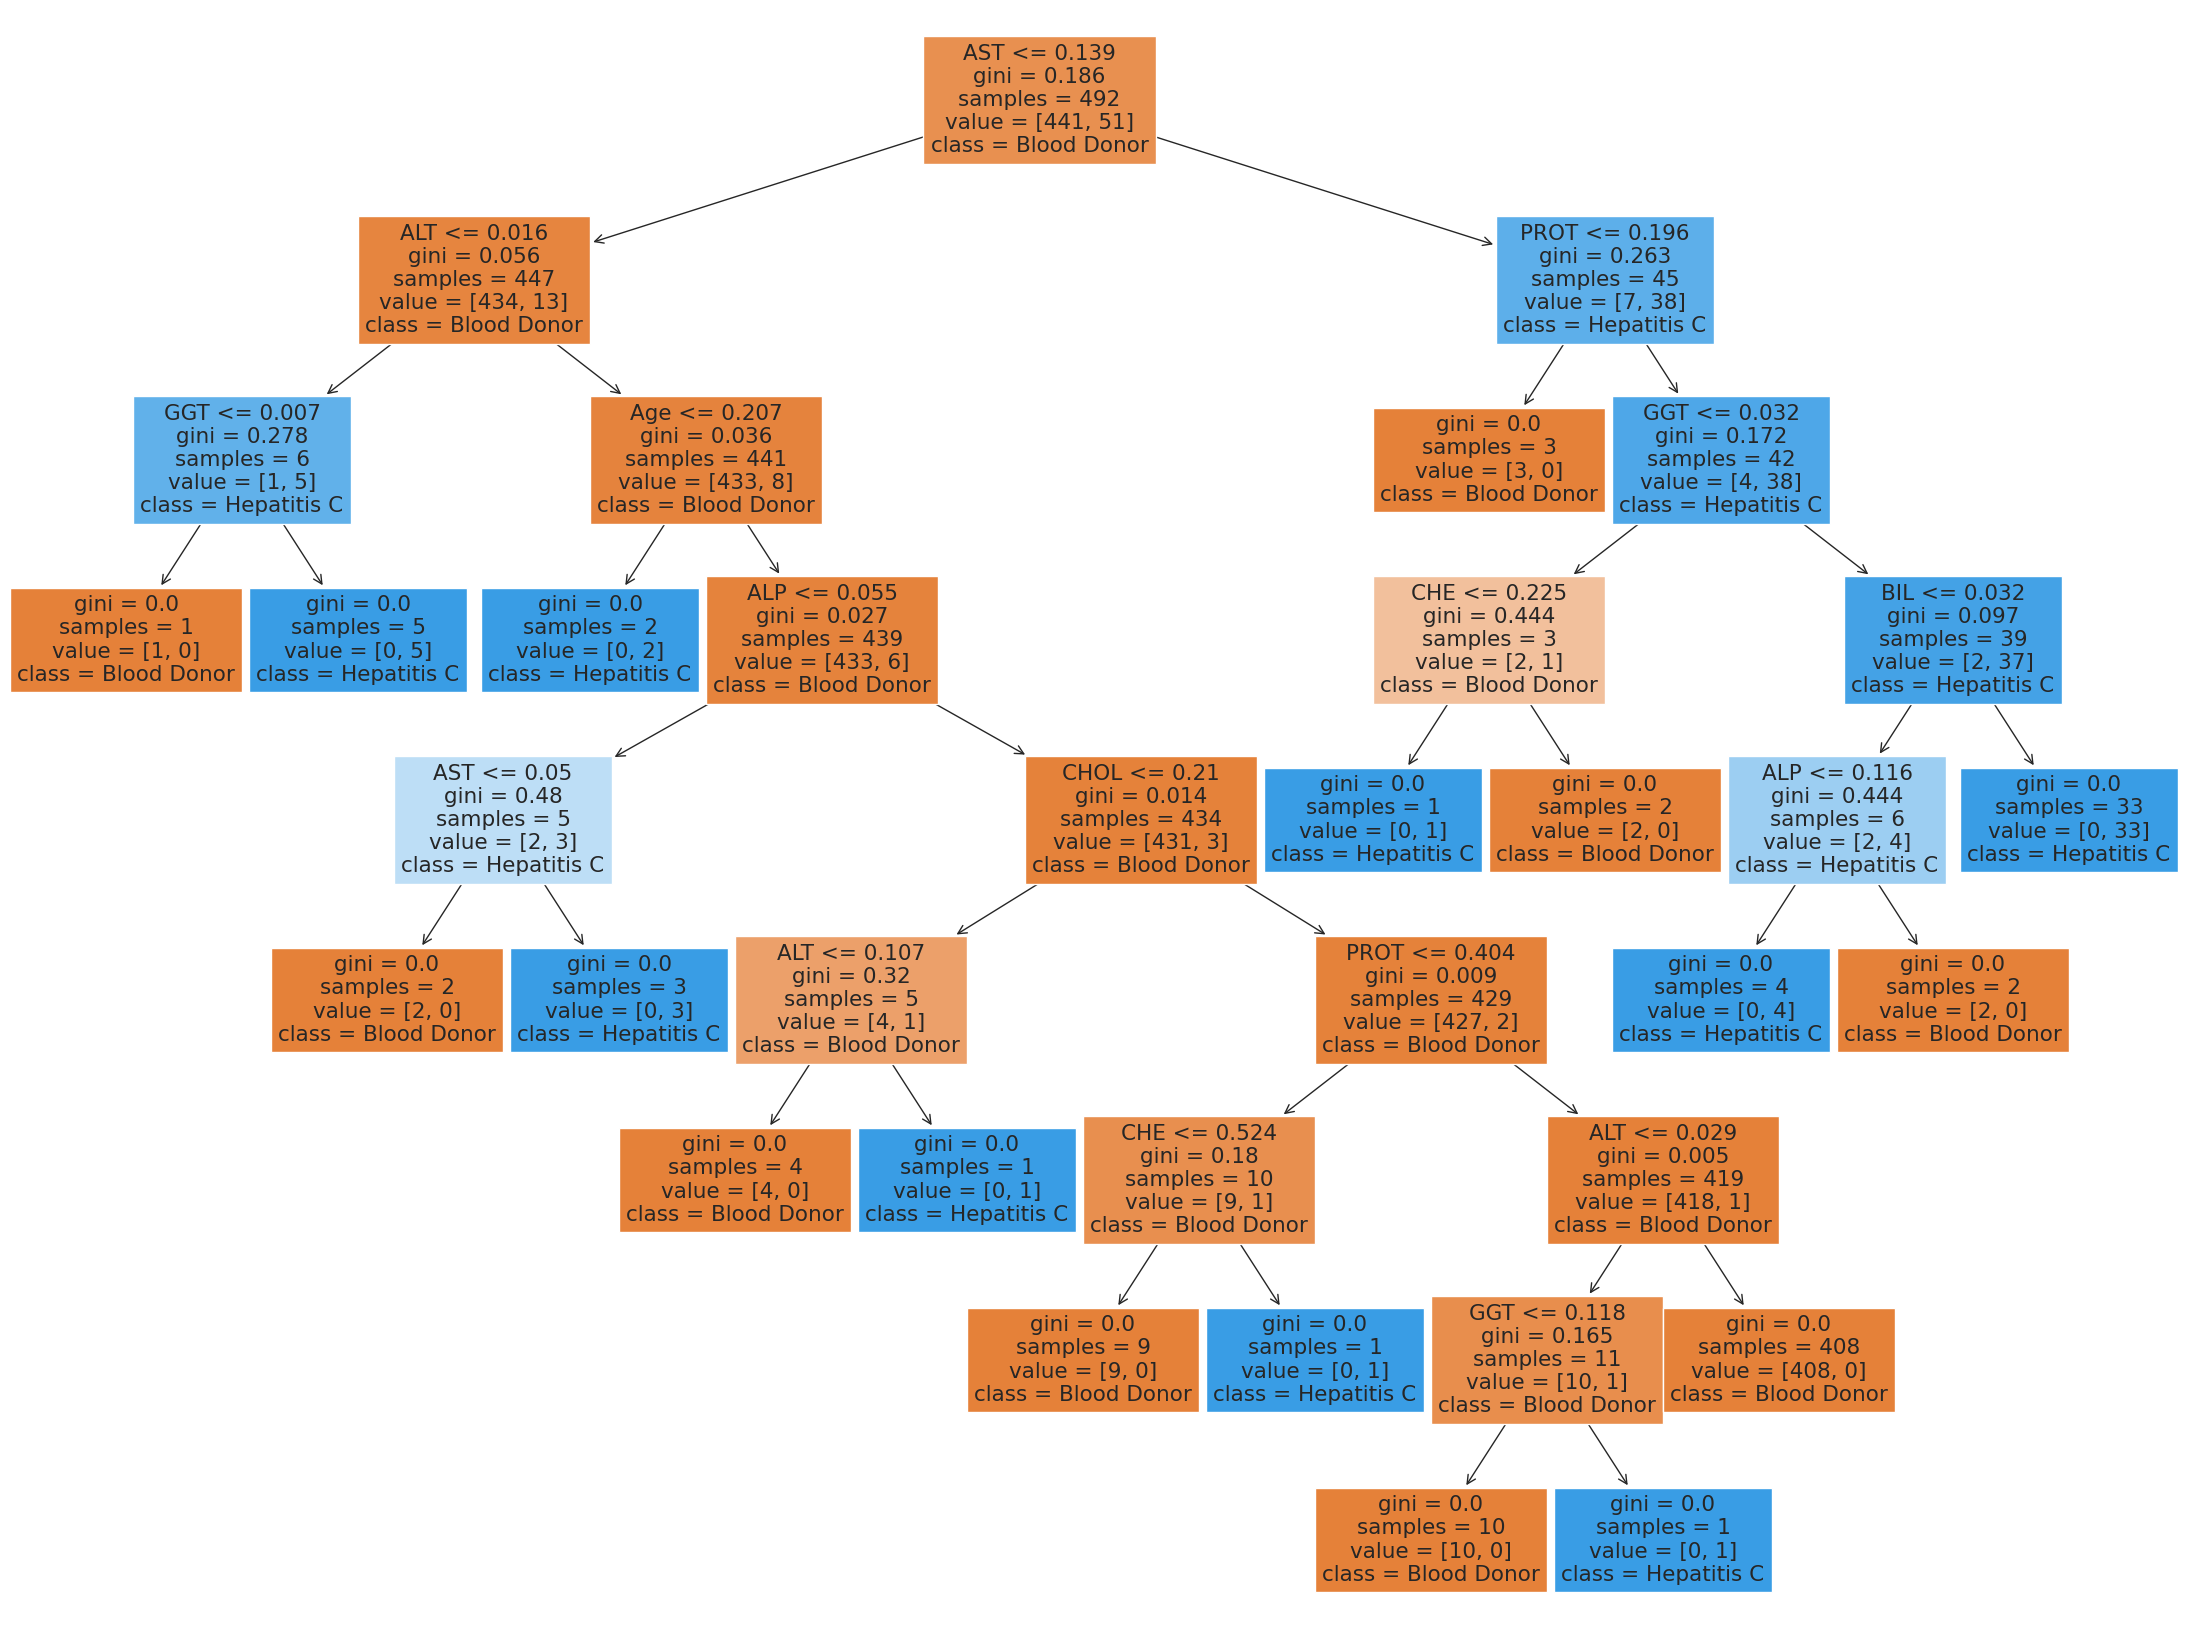

In [45]:
from sklearn import tree
graph1 = get_dt_graph(dt)

Evaluasi model default

In [46]:
evaluate_model(dt)

Train Accuracy : 1.0
Train Confusion Matrix:
[[441   0]
 [  0  51]]
--------------------------------------------------
Test Accuracy : 0.926829268292683
Test Confusion Matrix:
[[98  1]
 [ 8 16]]


**Decision Tree dengan kontrol depth off tree**

In [47]:
dt_depth = DecisionTreeClassifier(max_depth=3)
dt_depth.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

tree dengan max_depth = 3

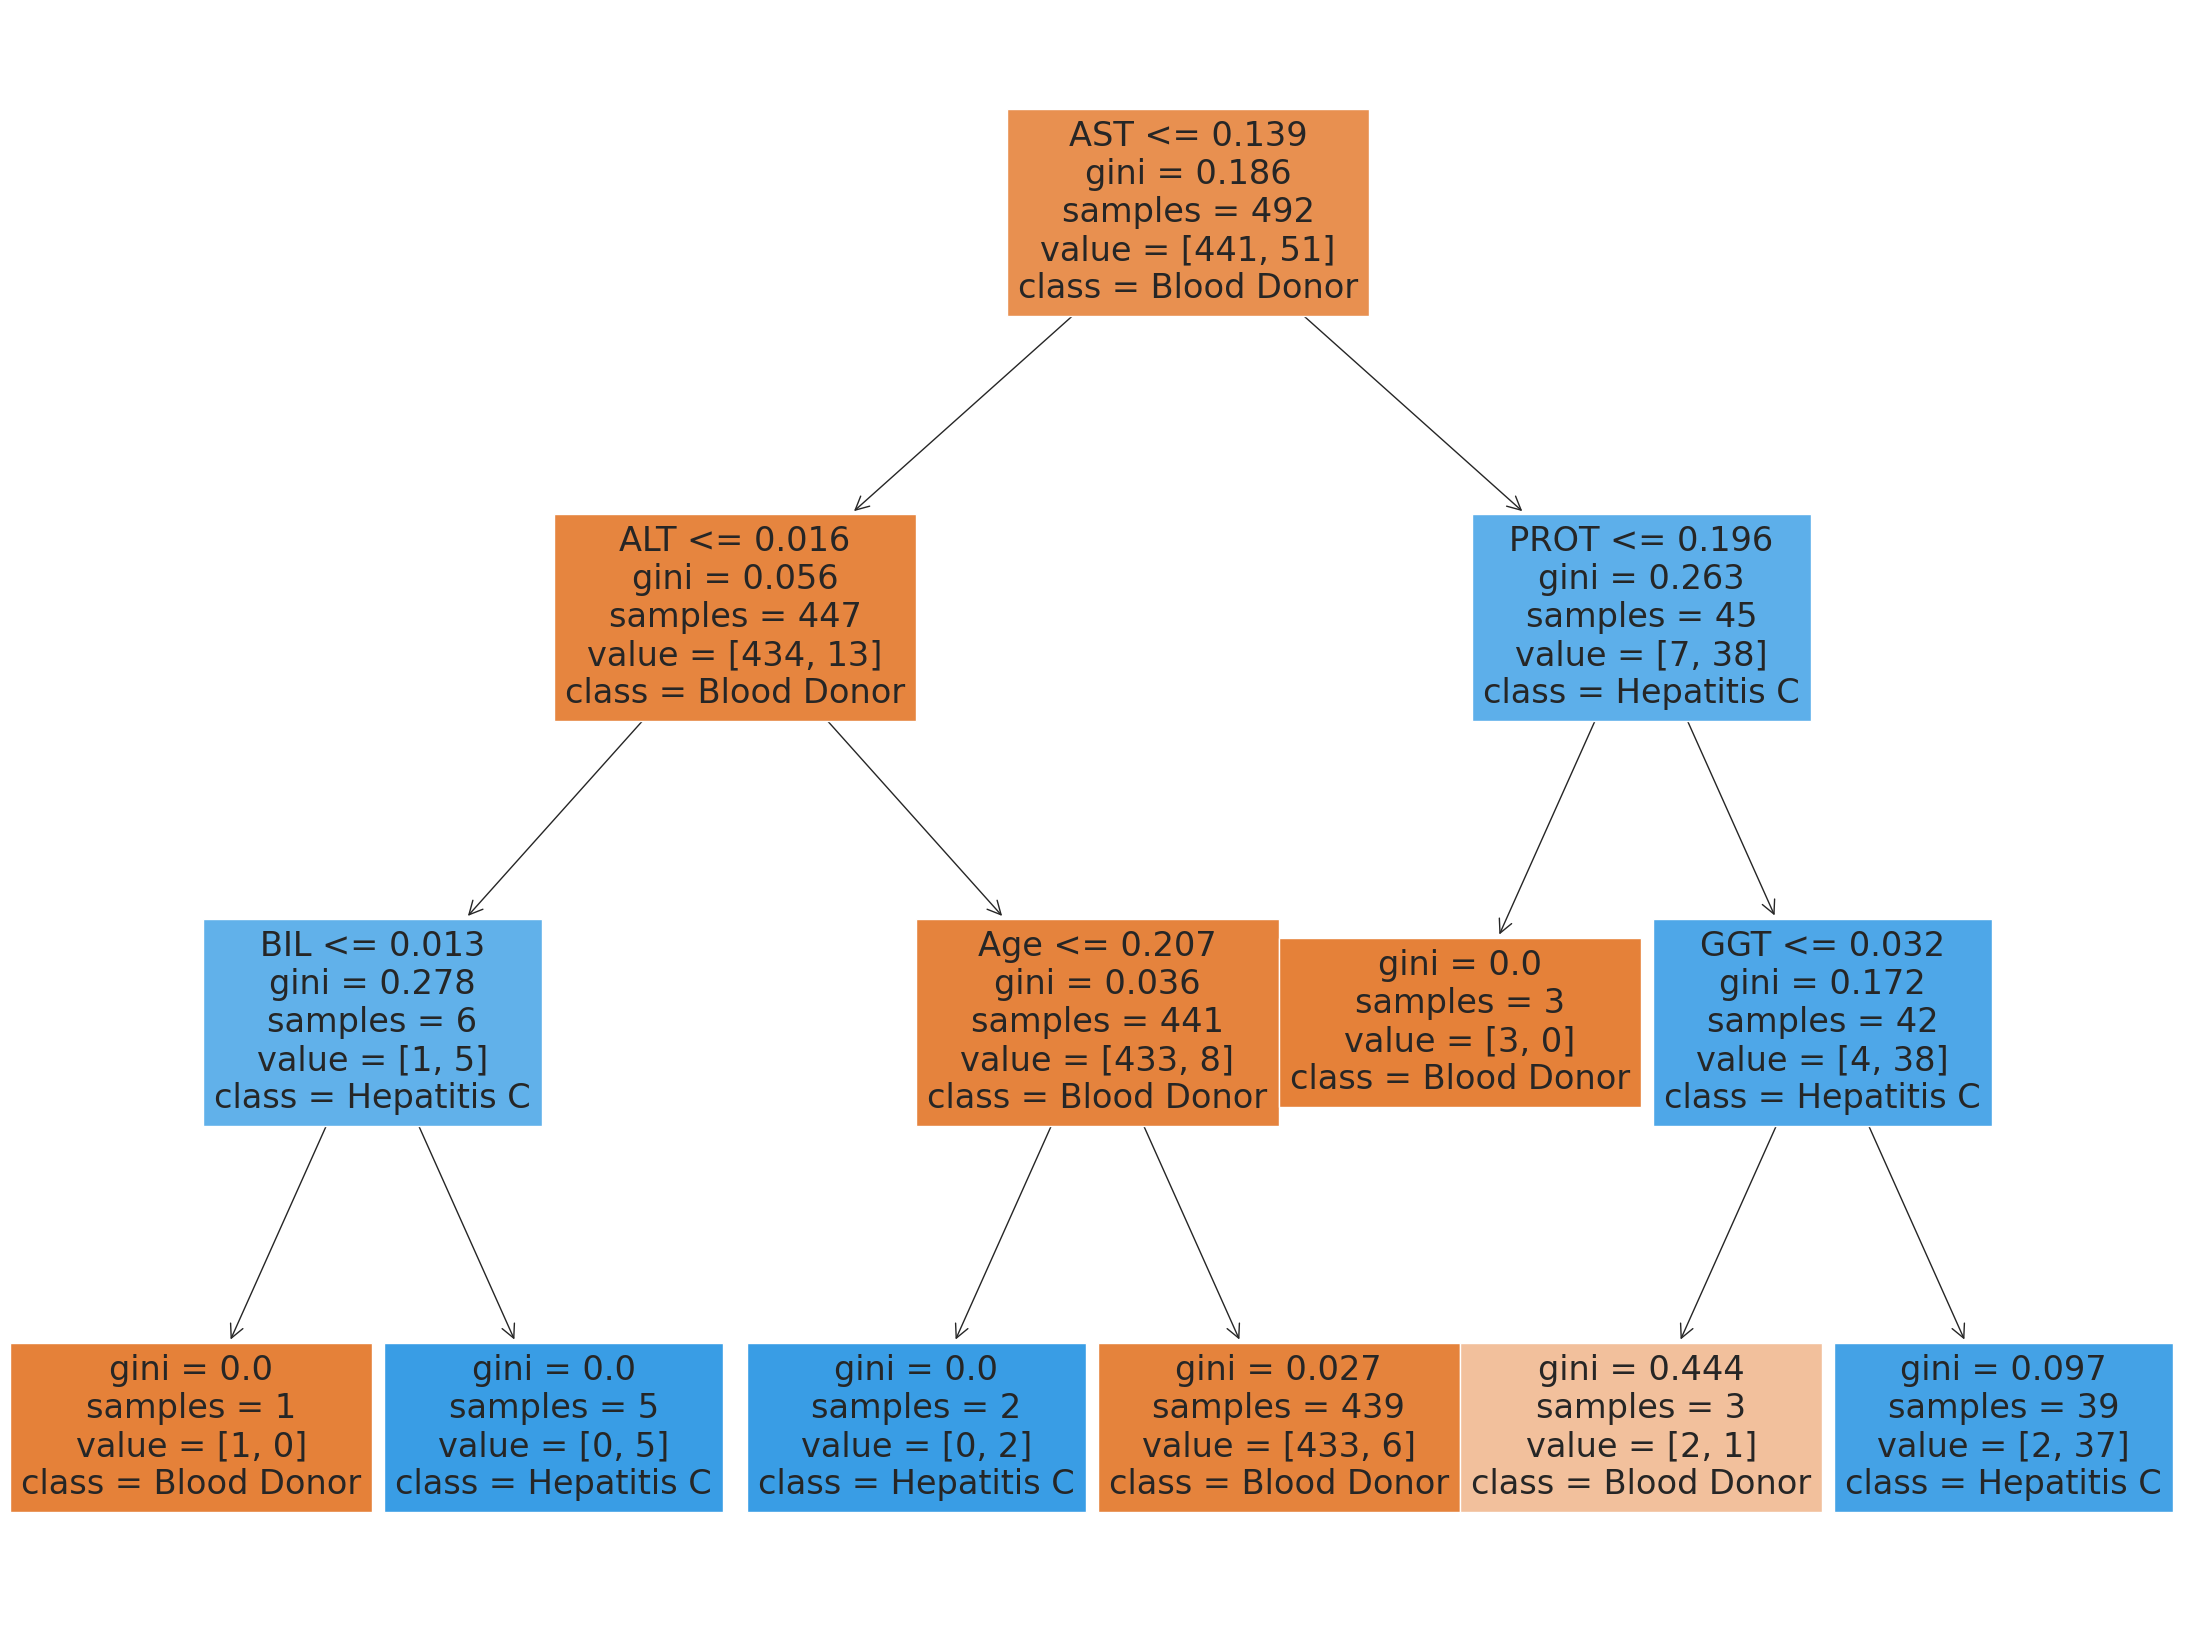

In [48]:
get_dt_graph(dt_depth)

Evaluasi model dengan max_depth=3

In [49]:
evaluate_model(dt_depth)

Train Accuracy : 0.9817073170731707
Train Confusion Matrix:
[[439   2]
 [  7  44]]
--------------------------------------------------
Test Accuracy : 0.9105691056910569
Test Confusion Matrix:
[[98  1]
 [10 14]]


**Decision tree dengan minimal sample split**

In [50]:
dt_split = DecisionTreeClassifier(min_samples_split=20)
dt_split.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_split=20)

tree dengan minimal sample split

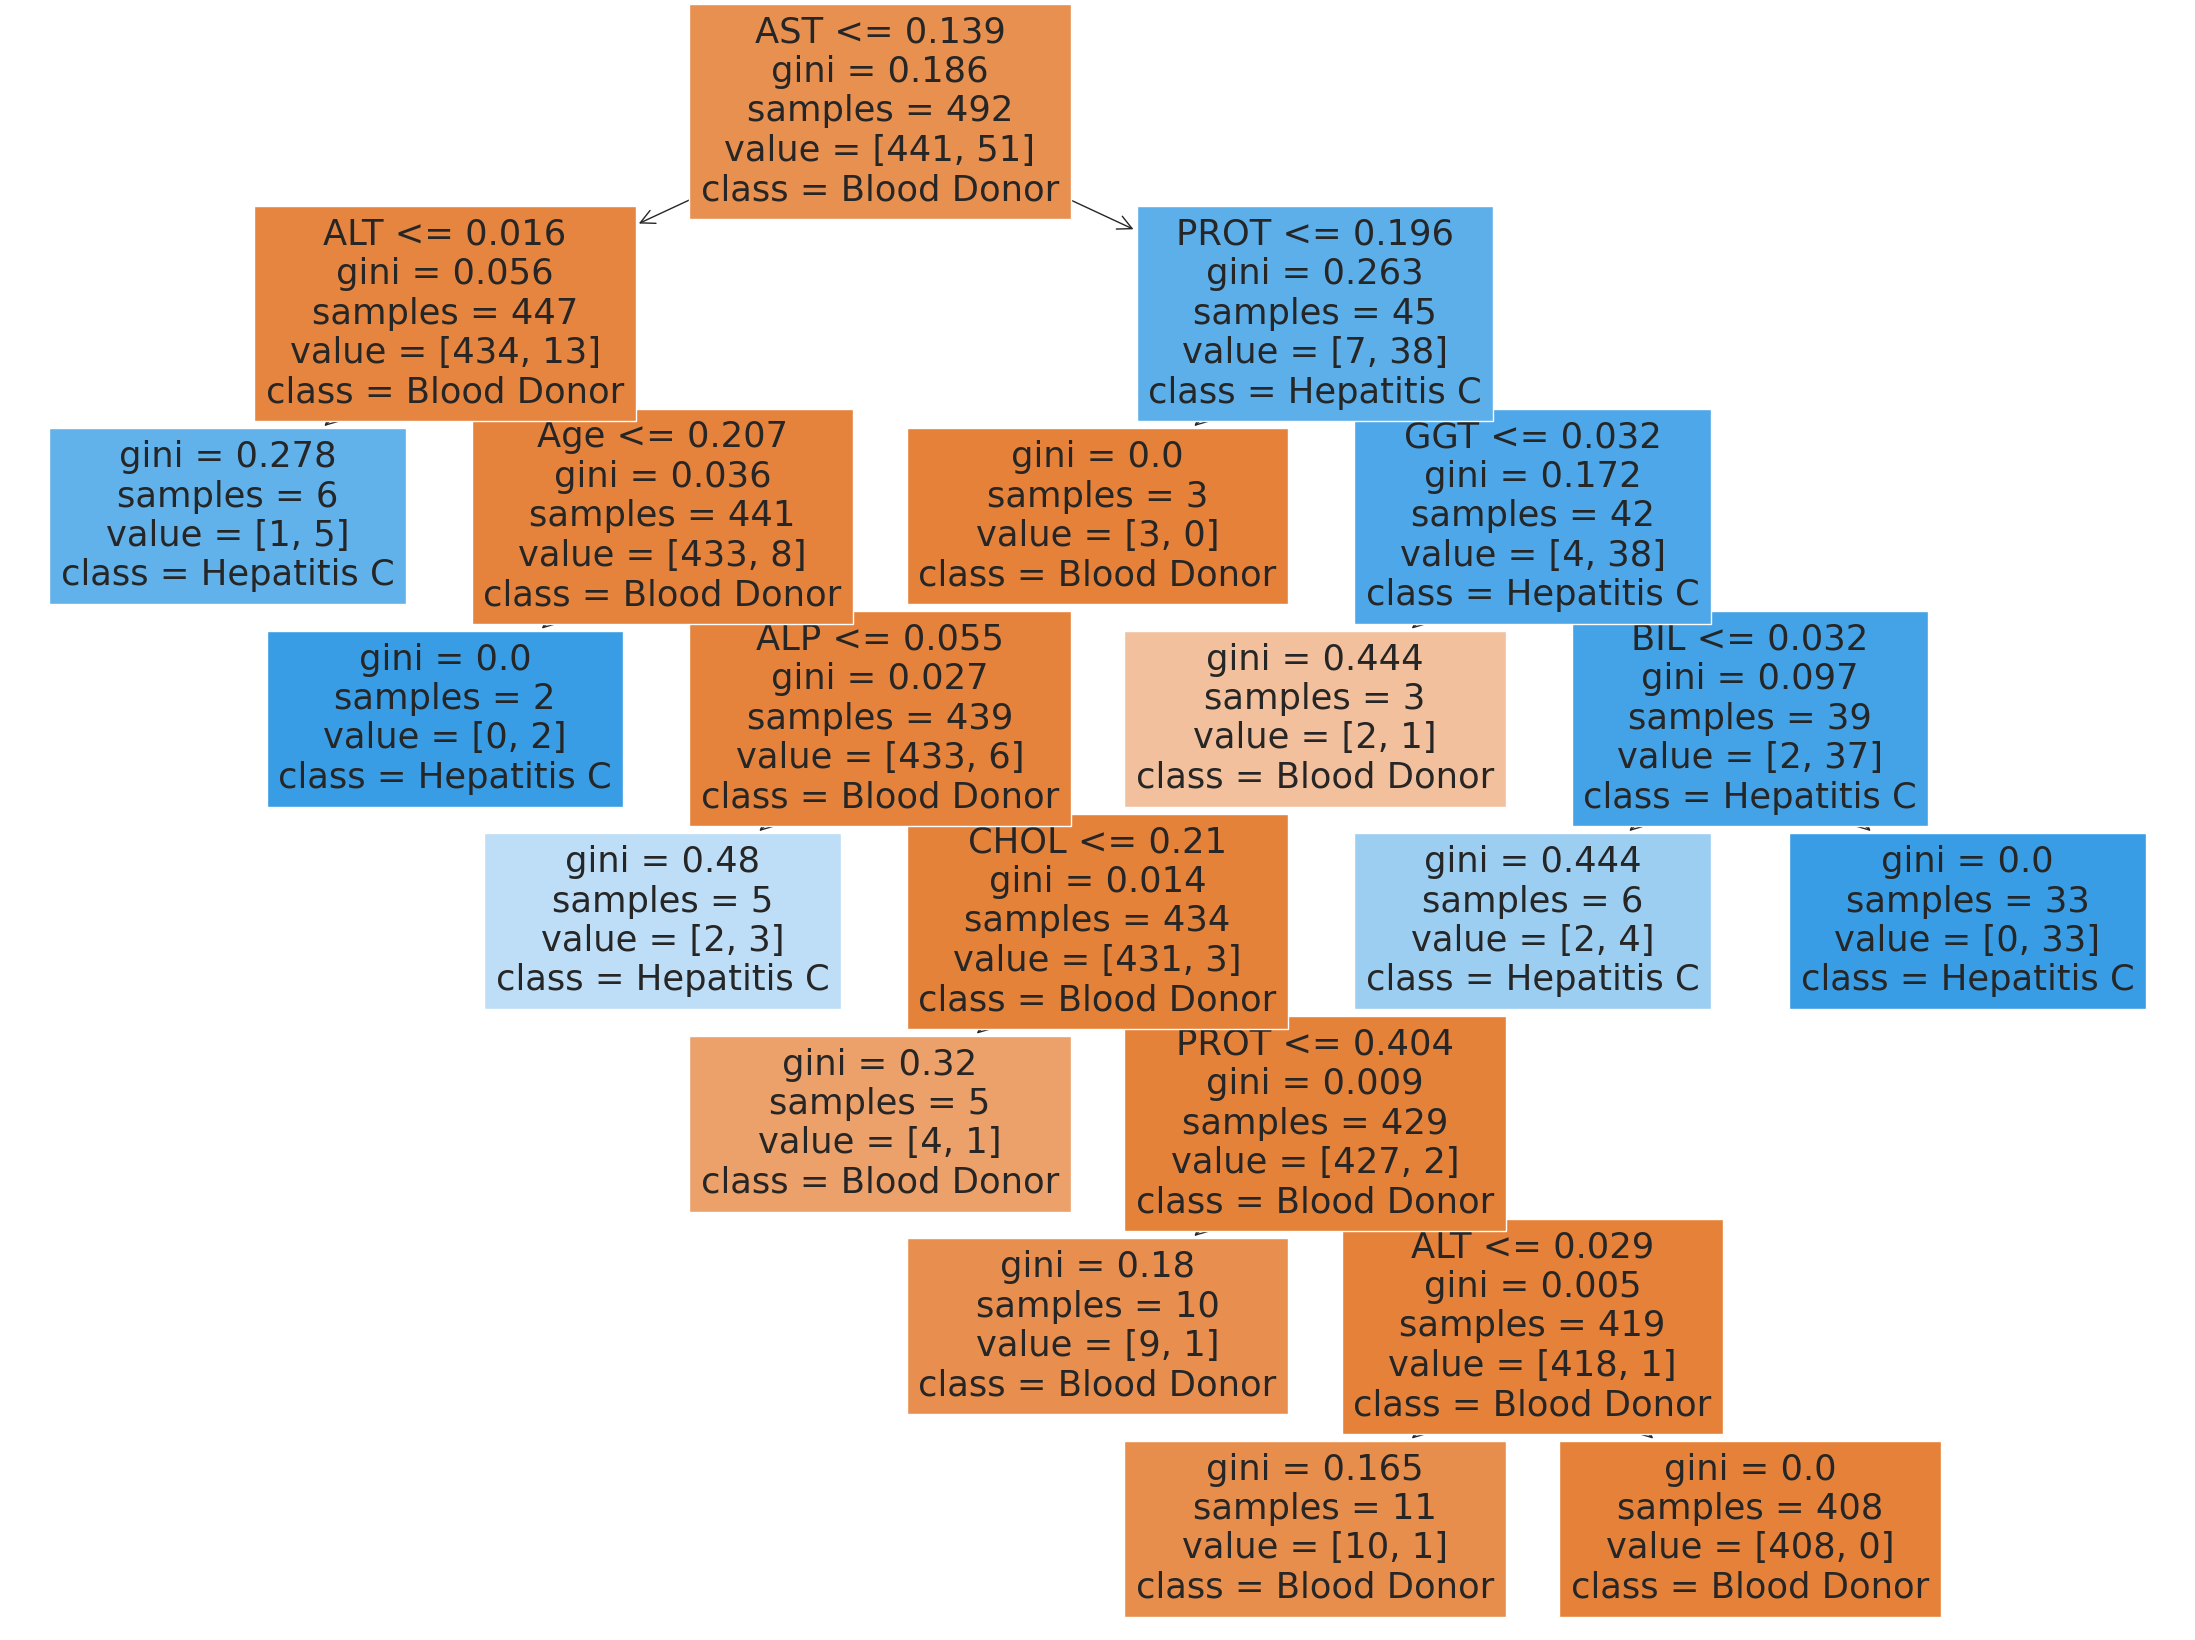

In [51]:
get_dt_graph(dt_split)

Evaluasi model dengan min sample split

In [52]:
evaluate_model(dt_split)

Train Accuracy : 0.9817073170731707
Train Confusion Matrix:
[[436   5]
 [  4  47]]
--------------------------------------------------
Test Accuracy : 0.9024390243902439
Test Confusion Matrix:
[[95  4]
 [ 8 16]]


**Decision tree dengan minimum sample leaf**

In [53]:
dt_leaf=DecisionTreeClassifier(min_samples_leaf=20, random_state=42)
dt_leaf.fit(X_train,y_train)

DecisionTreeClassifier(min_samples_leaf=20, random_state=42)

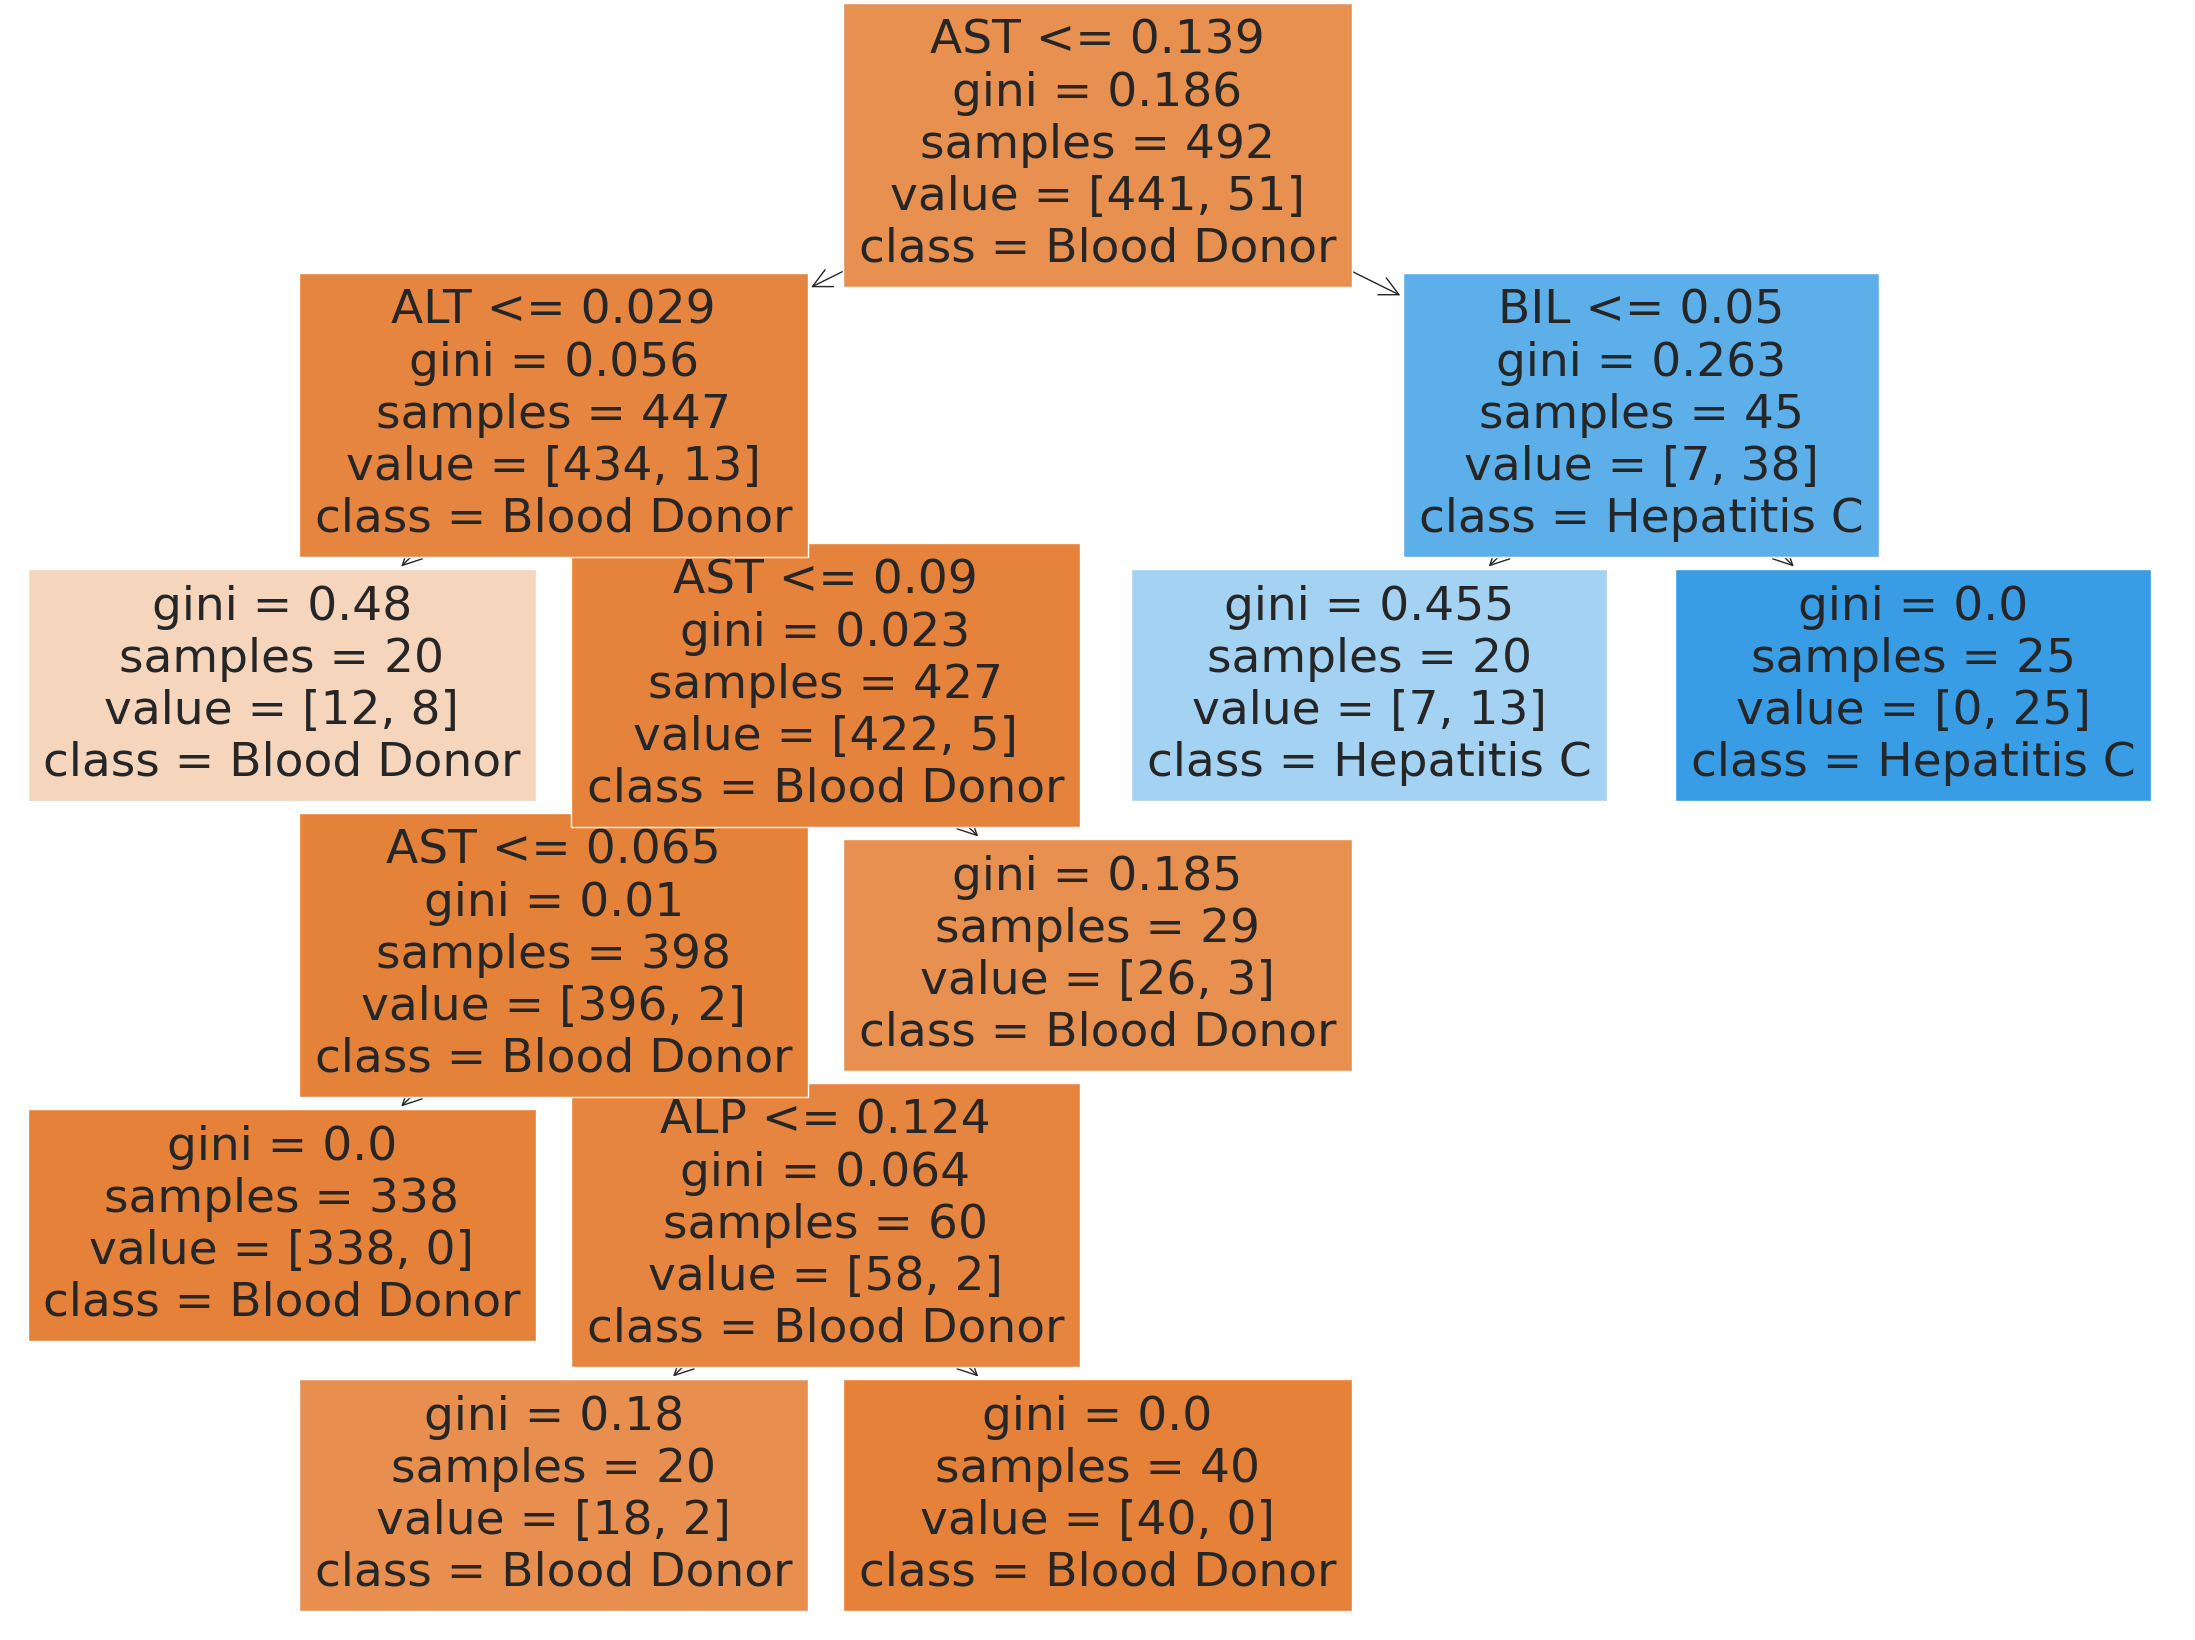

In [54]:
get_dt_graph(dt_leaf)

In [55]:
evaluate_model(dt_leaf)

Train Accuracy : 0.959349593495935
Train Confusion Matrix:
[[434   7]
 [ 13  38]]
--------------------------------------------------
Test Accuracy : 0.8861788617886179
Test Confusion Matrix:
[[98  1]
 [13 11]]


**Decision tree using entropy instead of gini**

In [56]:
dt_gini=DecisionTreeClassifier(min_samples_leaf=20, random_state=42, criterion="entropy")
dt_gini.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20,
                       random_state=42)

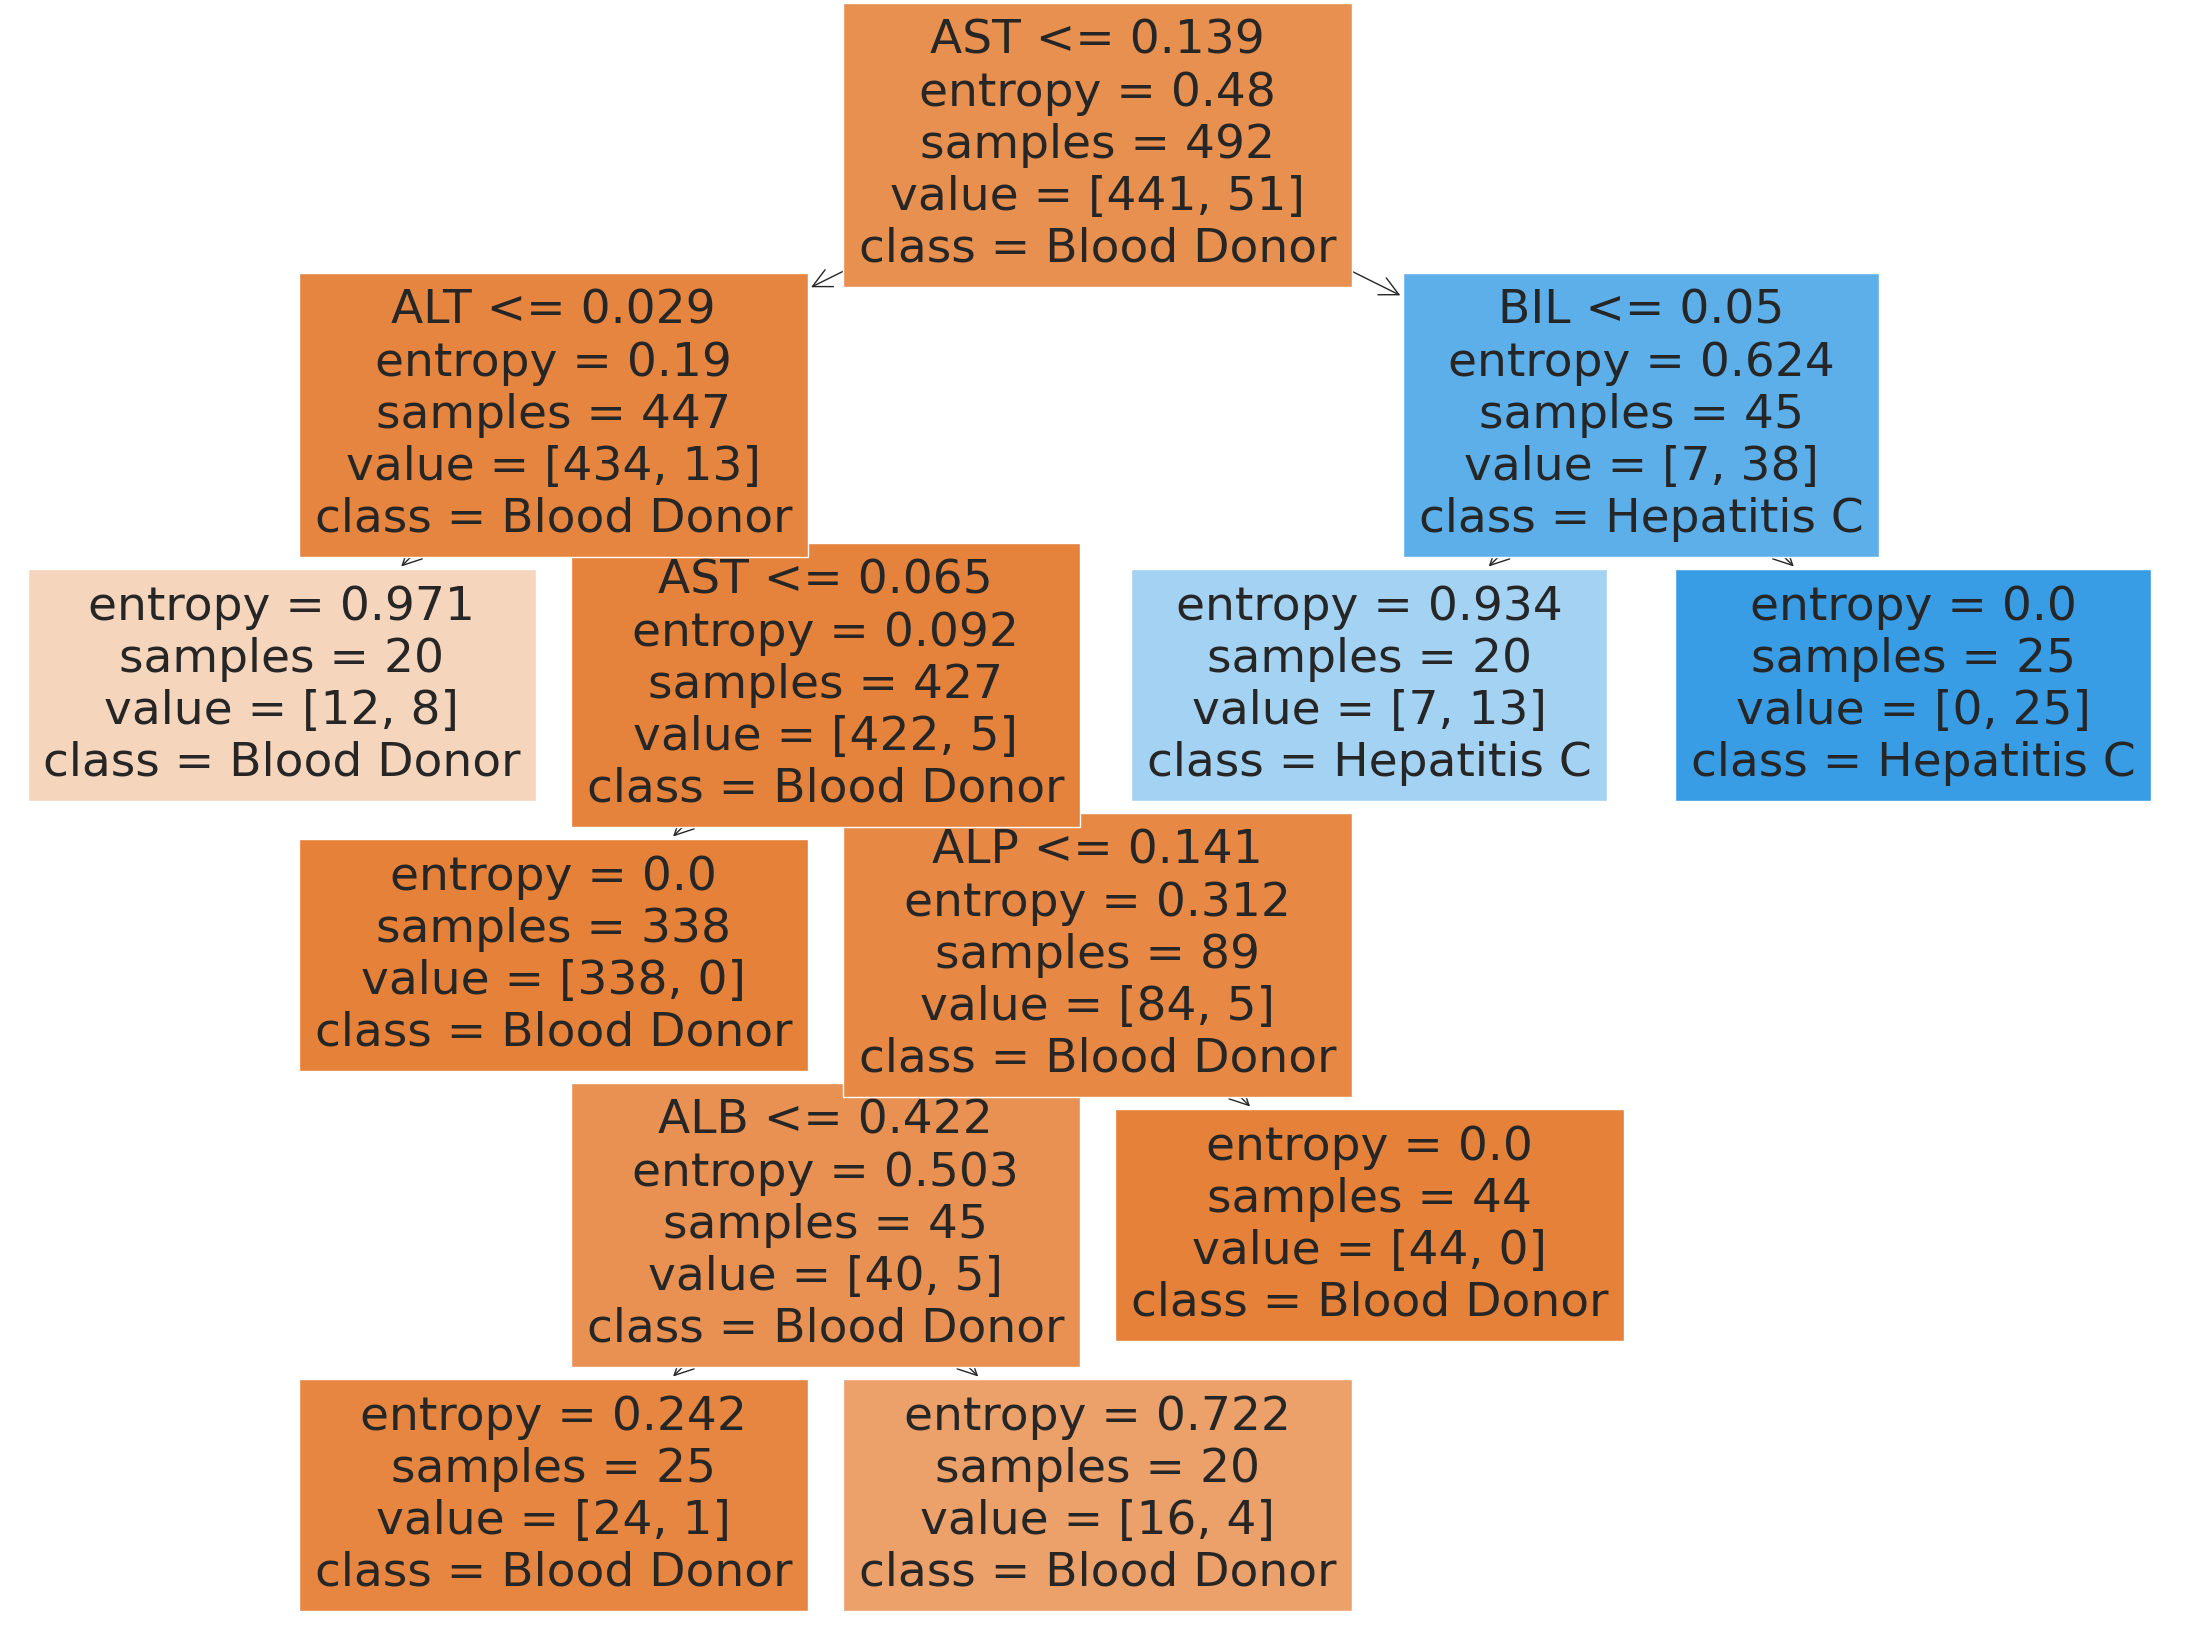

In [57]:
get_dt_graph(dt_gini)

In [58]:
evaluate_model(dt_gini)

Train Accuracy : 0.959349593495935
Train Confusion Matrix:
[[434   7]
 [ 13  38]]
--------------------------------------------------
Test Accuracy : 0.8861788617886179
Test Confusion Matrix:
[[98  1]
 [13 11]]


**HYPERPARAMETER TUNING**

Proses ini brtujuan untuk membentuk model dengan parameter terbaik, membuat grid parameter berdasarkan percobaan random sebelumnya. Hyperparameter tuning mensiasati agar supaya model tidak terjadi overfitting atau akurasi prediksi data train akurat sedangkan untuk akurasi data testing tidak akurat. 

In [59]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [60]:
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [61]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
CPU times: user 880 ms, sys: 150 ms, total: 1.03 s
Wall time: 3.03 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [62]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.nlargest(5,'mean_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2        0.006452      0.000226         0.003288        0.000091   
7        0.005609      0.000646         0.002999        0.000439   
12       0.005556      0.001405         0.002722        0.000710   
17       0.006396      0.000326         0.003379        0.000214   
22       0.006893      0.000563         0.003495        0.000220   

   param_criterion param_max_depth param_min_samples_leaf  \
2             gini               2                     20   
7             gini               3                     20   
12            gini               5                     20   
17            gini              10                     20   
22            gini              20                     20   

                                               params  split0_test_score  \
2   {'criterion': 'gini', 'max_depth': 2, 'min_sam...            0.96748   
7   {'criterion': 'gini', 'max_depth': 3, 'min_sam...            0.96748   
12  {'criterion': 'gini', 'max_depth': 5, 'min_sam...            0.96748   
17  {'criterion': 'gini', 'max_depth': 10, 'min_sa...            0.96748   
22  {'criterion': 'gini', 'max_depth': 20, 'min_sa...            0.96748   

    split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
2             0.95122            0.96748            0.95122          0.95935   
7             0.95122            0.96748            0.95122          0.95935   
12            0.95122            0.96748            0.95122          0.95935   
17            0.95122            0.96748            0.95122          0.95935   
22            0.95122            0.96748            0.95122          0.95935   

    std_test_score  rank_test_score  
2          0.00813                1  
7          0.00813                1  
12         0.00813                1  
17         0.00813                1  
22         0.00813                1

In [63]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=2, min_samples_leaf=20, random_state=42)

**Decision Tree dengan model terbaik**

In [64]:
dt_best = grid_search.best_estimator_

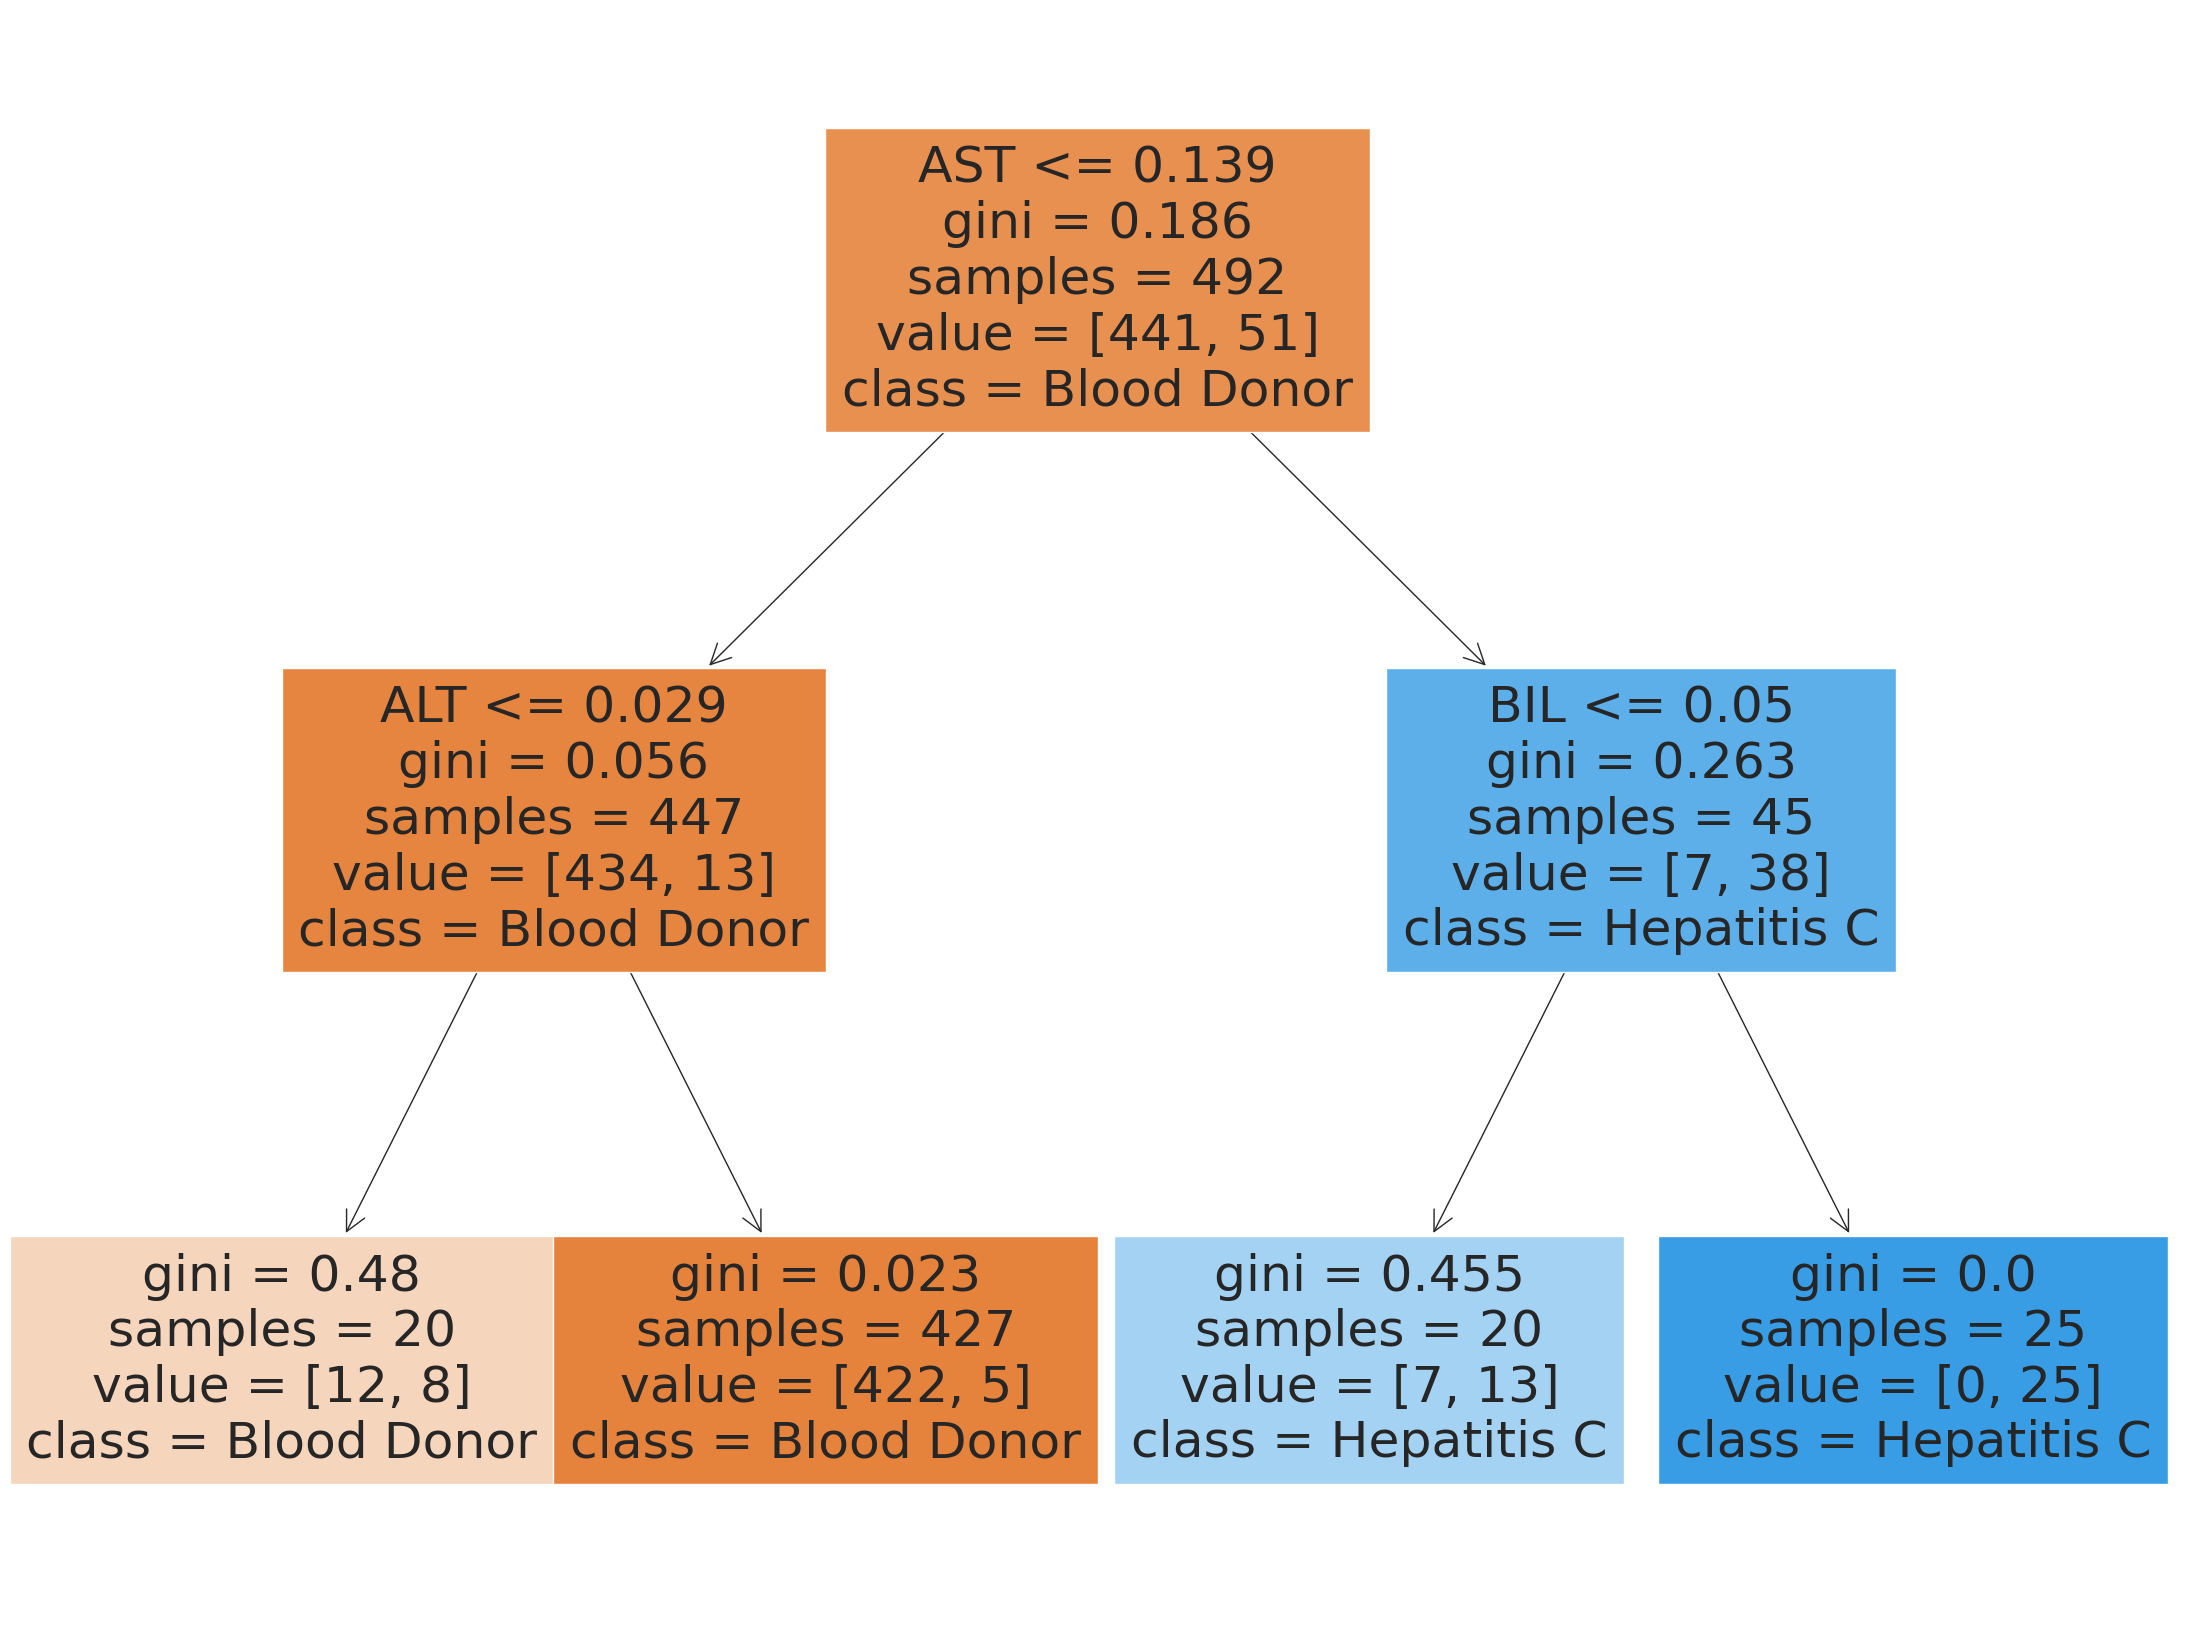

In [65]:
get_dt_graph(dt_best)

In [66]:
evaluate_model(dt_best)

Train Accuracy : 0.959349593495935
Train Confusion Matrix:
[[434   7]
 [ 13  38]]
--------------------------------------------------
Test Accuracy : 0.8861788617886179
Test Confusion Matrix:
[[98  1]
 [13 11]]


In [67]:
print(classification_report(y_test, dt_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93        99
           1       0.92      0.46      0.61        24

    accuracy                           0.89       123
   macro avg       0.90      0.72      0.77       123
weighted avg       0.89      0.89      0.87       123



Dari data diatas, didapatkan bahwa nilai akurasi model terbaik ialah sebesar 89

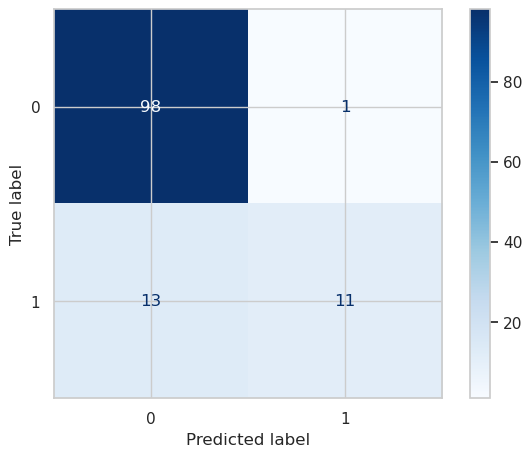

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_estimator(dt_best, X_test, y_test, cmap='Blues')

Berdasarkan confusion matrix diatas, didapatkan bahwa model memprediksi pasien dengan gejala Hepatitis C sebanyak 12 sedangkan pasien donor darah sebanyak 111

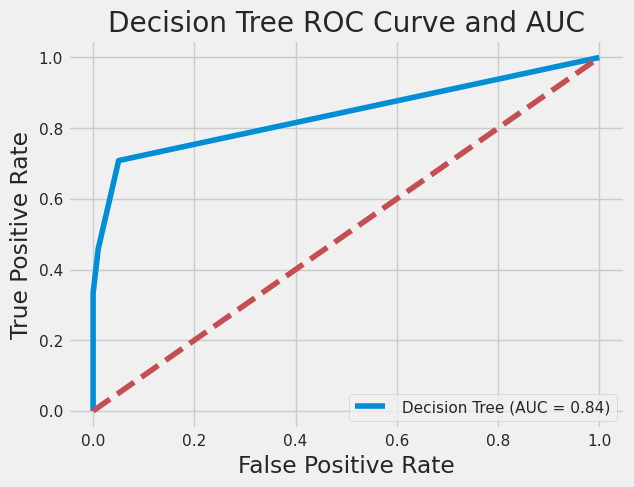

In [83]:
plot_roc_curve(dt_best,X_test,y_test, name =" Decision Tree")
plt.title("Decision Tree ROC Curve and AUC")
plt.plot([0,1],[0,1],"r--")
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

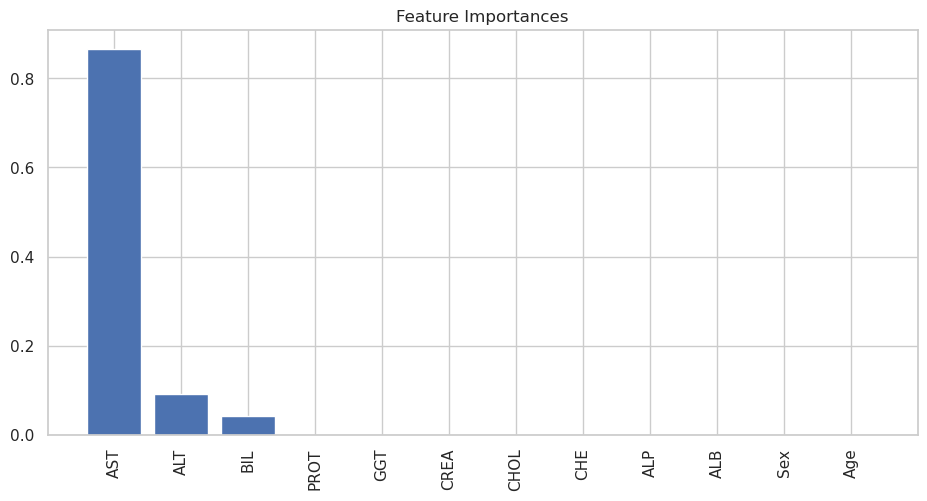

In [69]:
# get feature importances
importances = dt_best.feature_importances_

# get feature names
feature_names = X.columns

# sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# plot feature importances
plt.figure(figsize=(10,5))
plt.title("Feature Importances")
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), feature_names[indices], rotation='vertical')
plt.show()

In [77]:
# Get numerical feature importances
importances = list(dt_best.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: AST                  Importance: 0.87
Variable: ALT                  Importance: 0.09
Variable: BIL                  Importance: 0.04
Variable: Age                  Importance: 0.0
Variable: Sex                  Importance: 0.0
Variable: ALB                  Importance: 0.0
Variable: ALP                  Importance: 0.0
Variable: CHE                  Importance: 0.0
Variable: CHOL                 Importance: 0.0
Variable: CREA                 Importance: 0.0
Variable: GGT                  Importance: 0.0
Variable: PROT                 Importance: 0.0


Berdasarkan barplot diatas dapat disimpulkan bahwa features paling penting yang mempengaruhi hasil prediksi yaitu AST dengan proporsi 0.87.

# Conclusion

- Hasil prediksi yaitu 12 pasien positif hepatitis C dan 111 pasien donor darah
- Akurasi model terbaik yaitu 89%
- Nilai AUC yaitu 0.84
- Variabel dominan dalam prediksi berturut-turut yaitu Aspartate transminase (AST),Alanine transminase (ALT),dan BIL.